### Statistical Regression Sept 2022 Rating
Using the DES Job Seeker file

In [1]:
import datetime as dt
import re
import json
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from datetime import date, timedelta
from datetime import datetime
import warnings
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sn
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Reading in participant characteristics from the stream_participants and jobseeker table from the DB:

Files:
1. df_ap: statistical regression variables for each job seeker
2. dis_type = categorisation of participant disability type (mental or physical)

- Converting data types 
- Renaming the columns 
- Merge disability type dataframe with df_ap on disability_type_code

In [2]:
df_ap = pd.read_csv("C:/Users/AManalo/OneDrive - Arriba Group/Desktop/Star Ratings - AimBig/Stat Regression/ap_stat_variables.csv") # stream_participants + jobseeker 
dis_type = pd.read_csv("C:/Users/AManalo/OneDrive - Arriba Group/Desktop/Star Ratings - AimBig/Stat Regression/participant_disability_type.csv") # mental/physical disability mapping
dis_type.columns = map(str.upper, dis_type.columns)

# capitalising the column names in df_ap: 
df_ap = df_ap.rename(columns={'ess_identifier' : 'JOB_SEEKER_ID'})
df_ap.columns = map(str.upper, df_ap.columns)

df_ap['JOB_SEEKER_ID'] = pd.to_numeric(df_ap['JOB_SEEKER_ID'], errors='coerce')
df_ap = df_ap[df_ap['JOB_SEEKER_ID'].isna() == False]

df_ap['DISABILITY_TYPE_CODE'] = df_ap['DISABILITY_TYPE_CODE'].astype('object')
dis_type['DISABILITY_TYPE_CODE'] = dis_type['DISABILITY_TYPE_CODE'].astype('object')
# joining the disability type to the df_ap:
df_ap = df_ap.merge(dis_type, on=['DISABILITY_TYPE_CODE'])



df = df_ap




#### Missing values
- exploring the proportion of missing values

In [3]:
naVal = df.isna().sum() * 100 / len(df)
missValDf = pd.DataFrame({'column_name' : df.columns, 'percent_missing' : naVal})
missValDf.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
NATIONALITY,NATIONALITY,100.000000
EDUCATION,EDUCATION,100.000000
EDUCATION_CODE,EDUCATION_CODE,100.000000
CENTRELINK_OUTCOME_CODE,CENTRELINK_OUTCOME_CODE,90.443884
INTERPRETER_LANGUAGE_CODE,INTERPRETER_LANGUAGE_CODE,88.292305
AVAILABLE_DATE,AVAILABLE_DATE,40.899399
STATUS,STATUS,19.790657
RATE_TYPE,RATE_TYPE,19.790657
TIME_IN_PLACEMENT,TIME_IN_PLACEMENT,7.559605
TIME_IN_SITE,TIME_IN_SITE,6.086451


In [4]:
df.dtypes # types for each variable

JOB_SEEKER_ID                       float64
DATE_OF_BIRTH                        object
NATIONALITY                         float64
COUNTRY_OF_BIRTH                     object
EDUCATION                           float64
EDUCATION_CODE                      float64
CURRENT_CAPACITY_HOURS               object
GENDER                               object
INTERPRETER_LANGUAGE                 object
INTERPRETER_LANGUAGE_CODE            object
FUNDING_LEVEL_CODE                   object
RESIDENTIAL_ADDRESS_LINES            object
RESIDENTIAL_ADDRESS_SUBURB           object
RESIDENTIAL_ADDRESS_POSTCODE         object
RESIDENTIAL_ADDRESS_STATE            object
INDIGENOUS_IND                      float64
WAGE_SUBSIDY_ELIGIBLE               float64
RATE_TYPE                            object
AVAILABLE_DATE                       object
STATUS                               object
CENTRELINK_OUTCOME_CODE              object
ALLOWANCE_STARTED_ON                 object
ALLOWANCE_TYPE                  

Importing the pre-quarter 13 week outcomes file
- Converting job seeker to int type

In [5]:
df_13 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_13_pre.csv")
df_13 = df_13.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_13['JOB_SEEKER_ID'] = df_13['JOB_SEEKER_ID'].astype('int64')

print(str(len(df_13)) + ': 13 outcomes len')



4970: 13 outcomes len


Investigating the number of unique job seekers

In [6]:
df_13['JOB_SEEKER_ID'].nunique()
df['JOB_SEEKER_ID'].nunique()

5159

Renaming the disability_type variable to 'type' in main dataframe 'df'

In [7]:
df = df.rename(columns={'TYPE' : 'DISABILITY_TYPE'})

Subset the columns for analysis - all variables that we have:

In [8]:
df_sub = df[['DATE_OF_BIRTH', 'NATIONALITY', 'COUNTRY_OF_BIRTH', 'EDUCATION',
       'EDUCATION_CODE', 'CURRENT_CAPACITY_HOURS', 'JOB_SEEKER_ID', 'GENDER',
       'INTERPRETER_LANGUAGE', 'INTERPRETER_LANGUAGE_CODE',
       'FUNDING_LEVEL_CODE', 'RESIDENTIAL_ADDRESS_LINES',
       'RESIDENTIAL_ADDRESS_SUBURB', 'RESIDENTIAL_ADDRESS_STATE', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'RATE_TYPE', 'STATUS', 'CENTRELINK_OUTCOME_CODE',
       'ALLOWANCE_STARTED_ON', 'ALLOWANCE_TYPE', 'ALLOWANCE_RATE',
       'TIME_IN_PLACEMENT', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM',
       'TIME_IN_SITE', 'TIME_IN_PROVIDER', 'MODERATE_INTELLECTUAL_DISABILITY',
       'DISABILITY_TYPE', 'EMPLOYMENT_BENCHMARK']] 



Removing nationality, education, education_code, funding_level_code, centrelink_outcome_code, allowance_started_on, time_in_placement, disability_type_code, employment_benchmark 
- Ref to 'ap_stream_encoded_missing_reasons' excel file for reasons of exclusion

In [9]:
df_sub = df_sub.drop(columns=['NATIONALITY', 'EDUCATION', 'EDUCATION_CODE', 'FUNDING_LEVEL_CODE', 'CENTRELINK_OUTCOME_CODE', 'ALLOWANCE_STARTED_ON', 'TIME_IN_PLACEMENT', 'EMPLOYMENT_BENCHMARK', 'ALLOWANCE_TYPE', 'ALLOWANCE_RATE'], axis=1)


### Encoding the categorical variables 
- Binary encoding for Y,N variables
- JSCI_PERSONAL_FACTORS_OUTCOME: Nil, Low, Medium, High (0-3)

In [10]:
# disability_type: 0 for Mental, 1 for Physical
df_sub['DISABILITY_TYPE'] = df_sub['DISABILITY_TYPE'].dropna()
df_sub['DISABILITY_TYPE'] = np.where(df_sub['DISABILITY_TYPE'] == "mental", 0, 1)


In [11]:
df_sub.columns

Index(['DATE_OF_BIRTH', 'COUNTRY_OF_BIRTH', 'CURRENT_CAPACITY_HOURS',
       'JOB_SEEKER_ID', 'GENDER', 'INTERPRETER_LANGUAGE',
       'INTERPRETER_LANGUAGE_CODE', 'RESIDENTIAL_ADDRESS_LINES',
       'RESIDENTIAL_ADDRESS_SUBURB', 'RESIDENTIAL_ADDRESS_STATE',
       'RESIDENTIAL_ADDRESS_POSTCODE', 'INDIGENOUS_IND',
       'WAGE_SUBSIDY_ELIGIBLE', 'RATE_TYPE', 'STATUS', 'TIME_IN_STREAM',
       'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'DISABILITY_TYPE'],
      dtype='object')

In [12]:
df_sub['COUNTRY_OF_BIRTH'].value_counts()

Australia         3501
Vietnam            163
Iraq               160
China              134
United Kingdom     132
                  ... 
American Samoa       1
Yemen                1
Israel               1
Lithuania            1
Paraguay             1
Name: COUNTRY_OF_BIRTH, Length: 120, dtype: int64

For each value in each data variable (column), print the counts

In [13]:
col_names = ['DATE_OF_BIRTH', 'COUNTRY_OF_BIRTH',
       'CURRENT_CAPACITY_HOURS', 'JOB_SEEKER_ID', 'GENDER',
       'INTERPRETER_LANGUAGE', 'INTERPRETER_LANGUAGE_CODE',
       'RESIDENTIAL_ADDRESS_LINES', 'RESIDENTIAL_ADDRESS_SUBURB',
       'RESIDENTIAL_ADDRESS_STATE', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE',
       'TIME_IN_PROVIDER', 'MODERATE_INTELLECTUAL_DISABILITY']


for x in col_names:
    print('\n ' + str(x) + '\n', df_sub[x].value_counts())

# subsetting the features:
features = ['DATE_OF_BIRTH', 'COUNTRY_OF_BIRTH',
       'CURRENT_CAPACITY_HOURS', 'JOB_SEEKER_ID', 'GENDER',
       'INTERPRETER_LANGUAGE', 'INTERPRETER_LANGUAGE_CODE',
       'RESIDENTIAL_ADDRESS_LINES', 'RESIDENTIAL_ADDRESS_SUBURB',
       'RESIDENTIAL_ADDRESS_STATE', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE',
       'TIME_IN_PROVIDER', 'MODERATE_INTELLECTUAL_DISABILITY']





 DATE_OF_BIRTH
 13/10/1961 0:00    4
1/01/1971 0:00     4
1/07/1972 0:00     4
4/12/1958 0:00     4
16/11/1956 0:00    4
                  ..
14/10/1963 0:00    1
8/10/1959 0:00     1
17/03/1982 0:00    1
15/07/1960 0:00    1
15/11/1968 0:00    1
Name: DATE_OF_BIRTH, Length: 4393, dtype: int64

 COUNTRY_OF_BIRTH
 Australia         3501
Vietnam            163
Iraq               160
China              134
United Kingdom     132
                  ... 
American Samoa       1
Yemen                1
Israel               1
Lithuania            1
Paraguay             1
Name: COUNTRY_OF_BIRTH, Length: 120, dtype: int64

 CURRENT_CAPACITY_HOURS
 15-22     2725
Aug-14    1879
23-29      194
0-7        193
8+         125
30+         36
UNNOWN       2
Name: CURRENT_CAPACITY_HOURS, dtype: int64

 JOB_SEEKER_ID
 1.684700e+05    1
5.843230e+09    1
3.738479e+09    1
3.637480e+09    1
1.337853e+08    1
               ..
5.239655e+09    1
1.186267e+07    1
3.297211e+09    1
4.590001e+07    1
2.013135e+

Cleaning the columns

- Finding the Age from DATE_OF_BIRTH - Taking the AGE column 
- Age is from the end period of the Dec 2020 star ratings - at 8/01/21
- Dropping rows with more than 10 NULL column values 

In [14]:
df_sub = df_sub.dropna(thresh=10, axis=0) 

df_sub['DATE_OF_BIRTH'] = pd.to_datetime(df_sub['DATE_OF_BIRTH']).dt.date

end_date = datetime.strptime('2022/10/07', '%Y/%m/%d')
end_date_year = end_date.year
end_date_month = end_date.month
end_date_day = end_date.day

df_sub['AGE'] = df_sub['DATE_OF_BIRTH'].apply(lambda x: end_date_year - x.year - ((end_date_month, end_date_day) < (x.month, x.day)))
# converting Age -> INT
df_sub['AGE'] = df_sub['AGE'].astype('int64')
df_sub[['DATE_OF_BIRTH', 'AGE']]

,DATE_OF_BIRTH,AGE
0,1999-11-06,22
1,1996-09-18,26
2,1971-07-18,51
3,1985-03-29,37
4,1995-06-21,27
...,...,...
5154,1966-01-04,56
5155,1972-12-28,49
5156,1978-01-25,44
5157,1993-03-06,29


For participants that don't have an interpreter, replace values with 'NOT APPLICABLE'

In [15]:
df_sub['INTERPRETER_LANGUAGE'] = df_sub['INTERPRETER_LANGUAGE'].fillna('NOT APPLICABLE')
df_sub['INTERPRETER_LANGUAGE'].value_counts()

NOT APPLICABLE                    4555
Arabic                             172
Vietnamese                         118
Mandarin                            72
Cantonese                           37
Assyrian                            27
Persian (Farsi)                     24
Turkish                             21
Korean                              13
Chaldean                            12
Spanish                             10
Dari                                 9
Thai                                 6
Laos                                 5
Tamil                                4
CHINESE (WRITTEN)                    4
Indonesian                           4
TIGRINYA LANGUAGE FOR ETHIOPIA       3
Urdu                                 3
Tongan                               3
Samoan                               3
Chinese (Other)                      3
Greek                                3
Hindi                                3
Nepali                               3
Serbian                  

In [16]:
df_sub['MODERATE_INTELLECTUAL_DISABILITY'].value_counts()

False    5154
True        5
Name: MODERATE_INTELLECTUAL_DISABILITY, dtype: int64

In [17]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].value_counts()

0.0    3853
1.0    1306
Name: WAGE_SUBSIDY_ELIGIBLE, dtype: int64

In [18]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].isna().sum()  #NA value counts

0

### Encoding 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_SITE'
- WAGE_SUBSIDY_ELIGIBLE: encoded by maintaining the proportion of 1 to 0s 
- TIME_IN_SITE: encoded by the normal distribution of the values 

1. Plotting the distribution of WAGE_SUBSIDY_ELIGIBLE, TIME_IN_SITE

<AxesSubplot:>

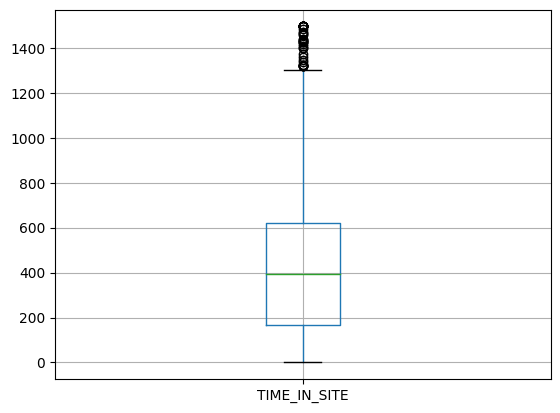

In [19]:
df_sub.boxplot(column=['TIME_IN_SITE'])

The distribution of TIME_IN_SITE is slightly left skewed, replace missing values with MEAN

In [20]:
mean_time_site = df_sub['TIME_IN_SITE'].mean()
df_sub['TIME_IN_SITE'] = df_sub['TIME_IN_SITE'].fillna(mean_time_site)


Replacing missing values in WAGE_SUBSIDY_ELIGIBLE with the proportion of existing values
### Part done MANUALLY in EXCEL -> filter on NULL values on WAGE_SUBSIDY_ELIGIBLE + rate_type (wage) + status (approved, etc.)


In [21]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].value_counts() # 0 - not eligible, 1 eligible

0.0    3853
1.0    1306
Name: WAGE_SUBSIDY_ELIGIBLE, dtype: int64

In [22]:
validRates = ['DES-DMS Wage Start Subsidy Payment', 'DES-DMS Wage Subsidy Fee', 'DES-ESS Wage Start Subsidy Payment', 'DES-ESS Wage Subsidy Fee', 'Restart Wage Subsidy DESA Payment', 'Restart Wage Subsidy DESB Payment', 'Restart Wage Subsidy DESB Payment', 'Restart Wage Subsidy Special Claim-DMS Job Seeker', 'Restart Wage Subsidy Special Claim-ESS Job Seeker']
validStatus = ['Approved', 'Pending', 'Lodged']



In [23]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].value_counts()

0.0    3853
1.0    1306
Name: WAGE_SUBSIDY_ELIGIBLE, dtype: int64

In [24]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].isna().sum() #-> replace with 0 -> assuming the manual replacement in EXCEL has been done

0

In [25]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'] = df_sub['WAGE_SUBSIDY_ELIGIBLE'].fillna(0)

The code cell below:
- For df_sub, encode categorical variables to numerical
- Create new column, 'COUNTRY_DIVERSE': if a participant was born outside of Australia, encode 1 (diverse), and 0 otherwise
- Create new column, 'CULTURAL_LINGUIST': if COUNTRY_DIVERSE is 1 AND INTERPRETER_LANGUAGE is 1 then 1, o otherwise
- For CURRENT_CAPACITY_HOURS, replace the string type values to numerical. For "Aug-14", replace with the midpoint value (8-14), which is encoded to 11. 
    - Remove UNKNOWN values
- For GENDER, female is 1, male is 0
- For MODERATE_INTELLECTUAL_DISABILITY: if value is 'False', then set to 0, else 1

In [26]:
# Cleaning the columns based on distinct values -->

df_sub['COUNTRY_OF_BIRTH'].isna().sum()
# 24 na's -> drop rows
df_sub = df_sub[df_sub['COUNTRY_OF_BIRTH'].notna()]


## INTERPRETER_LANGUAGE: if it is 'NOT APPLICABLE','NaN', 'Sign Language' -> then encode '0', otherwise '1'
no_inter = ['NOT APPLICABLE', 'NaN', 'Sign Language', '*', 'NULL']
df_sub['INTERPRETER_LANGUAGE'] = np.where(df_sub['INTERPRETER_LANGUAGE'].isin(no_inter), 0, 1)



# CULTURAL_linguist from 'COUNTRY_OF_BIRTH', 'INTERPRETER_LANGUAGE'
# if country_of_birth is NOT Australia, then 1 otherwise 0:
df_sub['COUNTRY_DIVERSE'] = np.where(df_sub['COUNTRY_OF_BIRTH'] != 'Australia', 1, 0)
df_sub['CULTURAL_LINGUIST'] = np.where((df_sub['COUNTRY_DIVERSE'] == 1) & (df_sub['INTERPRETER_LANGUAGE'] == 1), 1, 0)




## CURRENT_CAPACITY_HOURS: encode Aug-14 -> "8-14" range - but taking the midpoint  (and check with Depar why it would be Aug-14, should we use imputation?), remove NaN, remove UNKNOWN(count = 6)
# integer encoding with Midpoint (rounded down)

df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('Aug-14', '8-14')
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('NaN', 0)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('0-7', 3)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('8+', 8)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('8-14', 11)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('15-22', 18)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('23-29', 26)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('30+', 30)
df_sub = df_sub[df_sub['CURRENT_CAPACITY_HOURS'] != 'UNKNOWN']




## Gender: 0 for Male, 1 for Female
df_sub['GENDER'] = df_sub['GENDER'].replace('Female', 1)
df_sub['GENDER'] = df_sub['GENDER'].replace('Male', 0)


# Type conversions --
## INDIGENOUS_IND: Check that type is numeric 
## WAGE_SUBSIDY_ELIGIBLE: check type is numeric 

dict_types = {'INDIGENOUS_IND' : 'int', 'WAGE_SUBSIDY_ELIGIBLE' : 'int'}

df_sub = df_sub.astype(dict_types)

## MODERATE_INTELLECTUAL_DISABILITY - should include with 'DISABILITY_TYPE_CODE'? Or separately? - encode True, False with 0 and 1
df_sub['MODERATE_INTELLECTUAL_DISABILITY'] = np.where(df_sub['MODERATE_INTELLECTUAL_DISABILITY'] == False, 0, 1) 
# need to drop the 1
df_sub = df_sub[df_sub['MODERATE_INTELLECTUAL_DISABILITY'] != 1]



In [27]:
df_sub['INTERPRETER_LANGUAGE'].value_counts()

0    4550
1     604
Name: INTERPRETER_LANGUAGE, dtype: int64

In [28]:
df_sub['CURRENT_CAPACITY_HOURS'].value_counts()

18        2725
11        1878
26         194
3          191
8          123
30          36
UNNOWN       2
Name: CURRENT_CAPACITY_HOURS, dtype: int64

In [29]:
df_sub[['RESIDENTIAL_ADDRESS_LINES', 'RESIDENTIAL_ADDRESS_SUBURB', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'RESIDENTIAL_ADDRESS_STATE']]

,RESIDENTIAL_ADDRESS_LINES,RESIDENTIAL_ADDRESS_SUBURB,RESIDENTIAL_ADDRESS_POSTCODE,RESIDENTIAL_ADDRESS_STATE
0,8B EXETER RD,HOMEBUSH WEST,2140,NSW
1,34 CHURCHILL ST,FAIRFIELD,2165,NSW
2,U 16 6-10 OAKES ST,WESTMEAD,2145,NSW
3,15 ARGYLE PL,WEST PENNANT HILLS,2125,NSW
4,59 TRIBECA CCT,NORTH LAKES,4509,QLD
...,...,...,...,...
5154,21 SWIMMING POOL RD,TINGHA,2369,NSW
5155,5 HIDDEN VALLEY RD,BERRIMAH,828,NT
5156,57 REGENT ST,REGENTS PARK,2143,NSW
5157,188 SPRING ST,RESERVOIR,3073,VIC


Identifying the metro postcodes for each state
- Just using postcode and state
- Cleaning the columns

In [30]:
df_sub['RESIDENTIAL_ADDRESS_STATE'].value_counts()

NSW    2440
VIC    1360
QLD     936
SA      166
WA      111
TAS      82
NT       42
ACT      17
Name: RESIDENTIAL_ADDRESS_STATE, dtype: int64

In [31]:
# remove '*' in state
df_sub = df_sub[df_sub['RESIDENTIAL_ADDRESS_STATE'] != '*']
df_sub['RESIDENTIAL_ADDRESS_STATE'].value_counts()

# convert postcode to int
df_sub['RESIDENTIAL_ADDRESS_POSTCODE'] = df_sub['RESIDENTIAL_ADDRESS_POSTCODE'].astype('int64')

df_sub = df_sub[df_sub['GENDER'] != 'Unknown'] 

Based on metro postcodes from the following sources, nested lists are created for each metro area. 
The function, metro_postcode takes each post_code list and a postcode value (from the dataframe), and assigns 1 if metro, and 0 otherwise.
- Since postcodes are divided for each state, and the state information is provided as a separate column (residential_address_state), check the state matches with the postcode list being passed into the function. 

Metro postcodes for each state
source: https://support.shippit.com/hc/en-us/articles/4403703156377-Rule-to-Allocate-a-Courier-for-Metro-and-Regional-Destinations
Source: http://www.impactlists.com.au/ImpactLists/media/list-tools/Useful-Postcode-Ranges.pdf


In [32]:
### INDIGENOUS_STATUS and METRO LOCATION -> check address postcode AND state
df_sub['METRO'] = False # initialise the metro column to False values


# ind = 0 (start bounds), ind=1 (end bounds)
nsw_met = [[1000, 1920], [2000, 2239], [2555, 2574], [2740, 2786]] # sydney
qld_met = [[2484, 2494], [4000, 4370], [4373, 4381], [4400, 4405], [4500, 4580], [4600, 4610], [4614, 4618], [9000, 9919]] #brisbane
vic_met = [[3000, 3210], [3335, 3341], [3425, 3443], [3750, 3811], [3910, 3920], [3926, 3944], [3972, 3978], [3980, 3983], [8000, 8899]] #Melbourne
wa_met = [[6000, 6214], [6800, 6999]] #perth
tas_met = [[7000,7010], [7249,7250]] # hobart
sa_met = [[5000, 5199], [5800, 5999]] #adelaide
nt_met = [[800, 820], [900, 910]] # darwin
act_met = [[200,299], [2600, 2620], [2900,2920]] #canberra



# creating the "METRO" column - 1 if metro postcode, 0 otherwise
def metro_postcode(postcode_list, postcode):
    is_metro = False # initialise boolean 
    i = 0
    while i < len(postcode_list):
        start_bounds = int(postcode_list[i][0])
        end_bounds = int(postcode_list[i][1])
        if (postcode >= start_bounds) & ( postcode <= end_bounds):
            is_metro = True
            break
        i += 1

    return is_metro




# passing the postcodes to the 'metro_postcode' function ->
for i, row in df_sub.iterrows():
    x = df_sub['RESIDENTIAL_ADDRESS_POSTCODE'][i] #postcode
    if x is None:
        pass 
    else: 
        # getting the state
        state = df_sub['RESIDENTIAL_ADDRESS_STATE'][i]
        if state == 'NSW':
            df_sub['METRO'][i] = metro_postcode(nsw_met, x)
        elif state == 'QLD':
            df_sub['METRO'][i] = metro_postcode(qld_met, x)
        elif state == 'VIC':
            df_sub['METRO'][i] = metro_postcode(vic_met, x)
        elif state == 'WA':
            df_sub['METRO'][i] = metro_postcode(wa_met, x)
        elif state == 'TAS':
            df_sub['METRO'][i] = metro_postcode(tas_met, x)
        elif state == 'SA':
            df_sub['METRO'][i] = metro_postcode(sa_met, x)
        elif state == 'NT':
            df_sub['METRO'][i] = metro_postcode(nt_met, x)
        elif state == 'ACT':
            df_sub['METRO'][i] = metro_postcode(act_met, x)
        else: 
            pass



Indigenous metro (IND_METRO) column is set to '1' if the indigenous indicator is 1 AND the metro variable is 1. Else 0.

In [33]:
df_sub[["RESIDENTIAL_ADDRESS_POSTCODE", "RESIDENTIAL_ADDRESS_STATE", "METRO"]].head(5)
# encode True -> 1, False -> 0
df_sub["METRO"] = np.where(df_sub["METRO"] == True, 1, 0)

# filtering for INDIGENOUS_INDICATOR = 1 and METRO = 1
df_sub['IND_METRO'] = np.where((df_sub['INDIGENOUS_IND'] == 1) & (df_sub['METRO'] == 1), 1, 0) 

# output subset of dataframe on these columns to check:
df_sub[["RESIDENTIAL_ADDRESS_POSTCODE", "RESIDENTIAL_ADDRESS_STATE", "METRO", "INDIGENOUS_IND", "IND_METRO"]].head(10)

,RESIDENTIAL_ADDRESS_POSTCODE,RESIDENTIAL_ADDRESS_STATE,METRO,INDIGENOUS_IND,IND_METRO
0,2140,NSW,1,0,0
1,2165,NSW,1,0,0
2,2145,NSW,1,0,0
3,2125,NSW,1,0,0
4,4509,QLD,1,0,0
5,4066,QLD,1,0,0
6,6125,WA,1,0,0
7,2452,NSW,0,0,0
8,3199,VIC,1,0,0
9,2325,NSW,0,0,0


In [34]:
# Checking missing values again: 
naVal = df_sub.isna().sum() * 100 / len(df)
missValDf = pd.DataFrame({'column_name' : df_sub.columns, 'percent_missing' : naVal})
missValDf.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
INTERPRETER_LANGUAGE_CODE,INTERPRETER_LANGUAGE_CODE,88.176003
RATE_TYPE,RATE_TYPE,19.771274
STATUS,STATUS,19.771274
CURRENT_CAPACITY_HOURS,CURRENT_CAPACITY_HOURS,0.096918
METRO,METRO,0.000000
CULTURAL_LINGUIST,CULTURAL_LINGUIST,0.000000
COUNTRY_DIVERSE,COUNTRY_DIVERSE,0.000000
AGE,AGE,0.000000
DISABILITY_TYPE,DISABILITY_TYPE,0.000000
MODERATE_INTELLECTUAL_DISABILITY,MODERATE_INTELLECTUAL_DISABILITY,0.000000


In [35]:
# dropping the current_capacity_hours missing values
df_sub = df_sub[df_sub['CURRENT_CAPACITY_HOURS'].isna() == False]

Checking missing values after previous steps

In [36]:
naVal = df_sub.isna().sum() * 100 / len(df)
missValDf = pd.DataFrame({'column_name' : df_sub.columns, 'percent_missing' : naVal})
missValDf.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
INTERPRETER_LANGUAGE_CODE,INTERPRETER_LANGUAGE_CODE,88.079085
RATE_TYPE,RATE_TYPE,19.771274
STATUS,STATUS,19.771274
METRO,METRO,0.000000
CULTURAL_LINGUIST,CULTURAL_LINGUIST,0.000000
COUNTRY_DIVERSE,COUNTRY_DIVERSE,0.000000
AGE,AGE,0.000000
DISABILITY_TYPE,DISABILITY_TYPE,0.000000
MODERATE_INTELLECTUAL_DISABILITY,MODERATE_INTELLECTUAL_DISABILITY,0.000000
TIME_IN_PROVIDER,TIME_IN_PROVIDER,0.000000


### Final variables subset for logistic regression model

The names of columns (features) placed in a list -

In [37]:
features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']


# Identifying strong predictors for numerating participants
- Starting with the initial feature set, and choosing the best ones to satisfy a logistic regression model based on the assumptions:
    - Linearity: independent variables and logit of dependent variable have a linear relationship 
    - Independence: observations are independent of each other (entries are per individual participants)
    - No high correlation between independent variables
    - Dependent variable (numerator) is binary
    

In [38]:
#PCA
features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']


### Correlation Matrix
Between numeric variables

In [39]:
df_sub.dtypes

DATE_OF_BIRTH                        object
COUNTRY_OF_BIRTH                     object
CURRENT_CAPACITY_HOURS               object
JOB_SEEKER_ID                       float64
GENDER                               object
INTERPRETER_LANGUAGE                  int32
INTERPRETER_LANGUAGE_CODE            object
RESIDENTIAL_ADDRESS_LINES            object
RESIDENTIAL_ADDRESS_SUBURB           object
RESIDENTIAL_ADDRESS_STATE            object
RESIDENTIAL_ADDRESS_POSTCODE          int64
INDIGENOUS_IND                        int32
WAGE_SUBSIDY_ELIGIBLE                 int32
RATE_TYPE                            object
STATUS                               object
TIME_IN_STREAM                      float64
TIME_IN_PROGRAM                     float64
TIME_IN_SITE                        float64
TIME_IN_PROVIDER                    float64
MODERATE_INTELLECTUAL_DISABILITY      int32
DISABILITY_TYPE                       int32
AGE                                   int64
COUNTRY_DIVERSE                 

Checking whether there exists variable with all 0s or 1s -> to avoid PerfectSeparation error in the logistic regression

In [40]:
#for col in df_sub:
#    print(col , df_sub[col].unique())

In [41]:
df_feat = df_sub[['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']]
df_feat.corr()

,INDIGENOUS_IND,WAGE_SUBSIDY_ELIGIBLE,TIME_IN_STREAM,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,MODERATE_INTELLECTUAL_DISABILITY,AGE,COUNTRY_DIVERSE,CULTURAL_LINGUIST,IND_METRO
INDIGENOUS_IND,1.000000,0.008444,-0.002111,-0.004789,-0.012858,-0.020821,NaN,-0.079161,-0.176190,-0.092506,0.672204
WAGE_SUBSIDY_ELIGIBLE,0.008444,1.000000,0.543531,0.546893,0.291742,0.326438,NaN,-0.372430,-0.139535,-0.113886,0.014291
TIME_IN_STREAM,-0.002111,0.543531,1.000000,0.987074,0.525863,0.581360,NaN,-0.113418,-0.040352,-0.038666,-0.008153
TIME_IN_PROGRAM,-0.004789,0.546893,0.987074,1.000000,0.531786,0.586480,NaN,-0.114106,-0.039974,-0.034105,-0.011211
TIME_IN_SITE,-0.012858,0.291742,0.525863,0.531786,1.000000,0.844031,NaN,0.072617,0.016916,-0.008365,0.000080
TIME_IN_PROVIDER,-0.020821,0.326438,0.581360,0.586480,0.844031,1.000000,NaN,0.064667,0.019944,0.003773,0.000419
MODERATE_INTELLECTUAL_DISABILITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,-0.079161,-0.372430,-0.113418,-0.114106,0.072617,0.064667,NaN,1.000000,0.319595,0.220991,-0.053738
COUNTRY_DIVERSE,-0.176190,-0.139535,-0.040352,-0.039974,0.016916,0.019944,NaN,0.319595,1.000000,0.523983,-0.116994
CULTURAL_LINGUIST,-0.092506,-0.113886,-0.038666,-0.034105,-0.008365,0.003773,NaN,0.220991,0.523983,1.000000,-0.063844


Dropping the NaN correlation variables

In [42]:
df_feat =  df_sub[['CURRENT_CAPACITY_HOURS', 'GENDER', 'DISABILITY_TYPE', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']]

corr_matrix = df_feat.corr()
corr_matrix.style.background_gradient(cmap='Blues')

,DISABILITY_TYPE,INDIGENOUS_IND,WAGE_SUBSIDY_ELIGIBLE,TIME_IN_STREAM,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,AGE,COUNTRY_DIVERSE,CULTURAL_LINGUIST,IND_METRO
DISABILITY_TYPE,1.000000,-0.057563,-0.164321,-0.059222,-0.061921,0.050046,0.037597,0.391178,0.231542,0.205478,-0.050173
INDIGENOUS_IND,-0.057563,1.000000,0.008444,-0.002111,-0.004789,-0.012858,-0.020821,-0.079161,-0.176190,-0.092506,0.672204
WAGE_SUBSIDY_ELIGIBLE,-0.164321,0.008444,1.000000,0.543531,0.546893,0.291742,0.326438,-0.372430,-0.139535,-0.113886,0.014291
TIME_IN_STREAM,-0.059222,-0.002111,0.543531,1.000000,0.987074,0.525863,0.581360,-0.113418,-0.040352,-0.038666,-0.008153
TIME_IN_PROGRAM,-0.061921,-0.004789,0.546893,0.987074,1.000000,0.531786,0.586480,-0.114106,-0.039974,-0.034105,-0.011211
TIME_IN_SITE,0.050046,-0.012858,0.291742,0.525863,0.531786,1.000000,0.844031,0.072617,0.016916,-0.008365,0.000080
TIME_IN_PROVIDER,0.037597,-0.020821,0.326438,0.581360,0.586480,0.844031,1.000000,0.064667,0.019944,0.003773,0.000419
AGE,0.391178,-0.079161,-0.372430,-0.113418,-0.114106,0.072617,0.064667,1.000000,0.319595,0.220991,-0.053738
COUNTRY_DIVERSE,0.231542,-0.176190,-0.139535,-0.040352,-0.039974,0.016916,0.019944,0.319595,1.000000,0.523983,-0.116994
CULTURAL_LINGUIST,0.205478,-0.092506,-0.113886,-0.038666,-0.034105,-0.008365,0.003773,0.220991,0.523983,1.000000,-0.063844


### Relationships between Features Chart

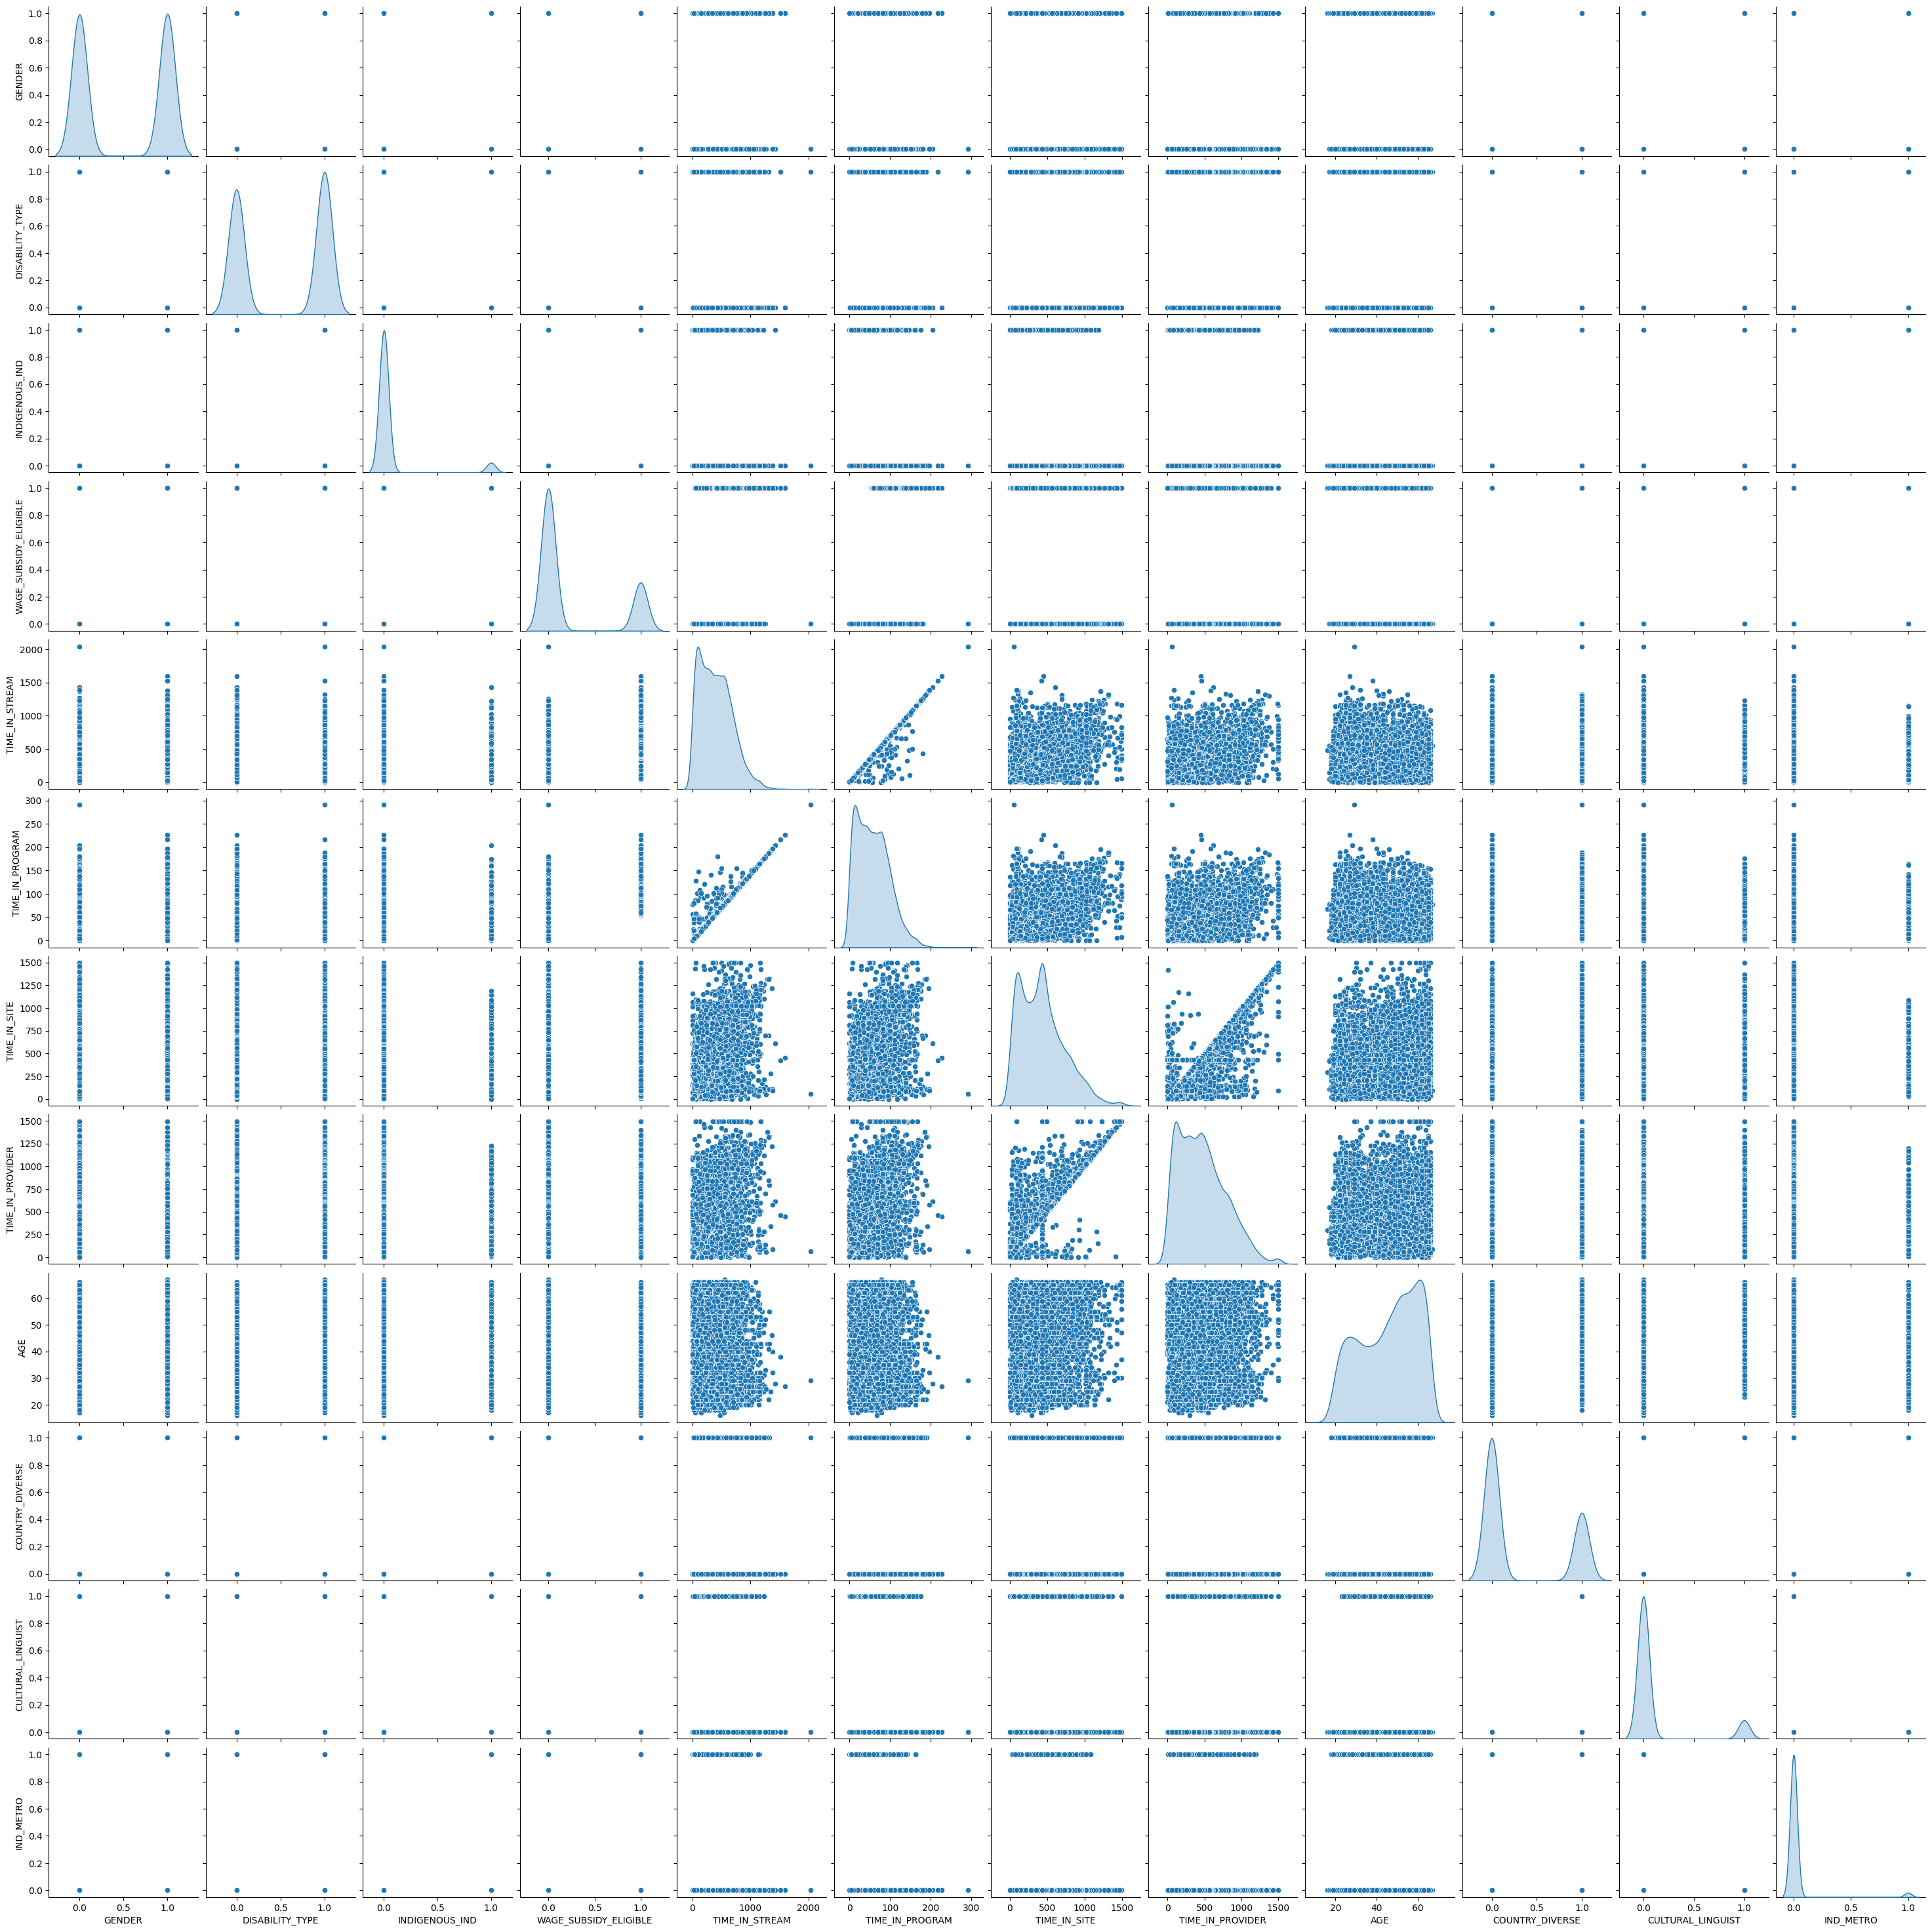

In [43]:
import seaborn as sns
df_feat_num =  df_sub[['CURRENT_CAPACITY_HOURS', 'GENDER', 'DISABILITY_TYPE', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']]
sns.pairplot(data = df_feat_num, diag_kind='kde')
plt.show()

**Linearity assumption check**
- Investigating the relationship between each variable and the dependent logit (log odds of a an event occuring (numerator=1 or numerator = 0))
- However sine the numerator is on a per performance measure basis, need to do for all dataframes (13, 26, 52)

In [44]:
df_sub['JOB_SEEKER_ID'] = df_sub['JOB_SEEKER_ID'].astype('int64')

In [45]:
df_sub

,DATE_OF_BIRTH,COUNTRY_OF_BIRTH,CURRENT_CAPACITY_HOURS,JOB_SEEKER_ID,GENDER,INTERPRETER_LANGUAGE,INTERPRETER_LANGUAGE_CODE,RESIDENTIAL_ADDRESS_LINES,RESIDENTIAL_ADDRESS_SUBURB,RESIDENTIAL_ADDRESS_STATE,...,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,MODERATE_INTELLECTUAL_DISABILITY,DISABILITY_TYPE,AGE,COUNTRY_DIVERSE,CULTURAL_LINGUIST,METRO,IND_METRO
0,1999-11-06,Australia,11,168470,1,0,NaN,8B EXETER RD,HOMEBUSH WEST,NSW,...,118.0,800.000000,829.0,0,1,22,0,0,1,0
1,1996-09-18,Australia,8,3091044909,0,0,NaN,34 CHURCHILL ST,FAIRFIELD,NSW,...,77.0,530.000000,544.0,0,1,26,0,0,1,0
2,1971-07-18,Australia,11,9690339309,1,0,NaN,U 16 6-10 OAKES ST,WESTMEAD,NSW,...,112.0,1009.000000,1011.0,0,1,51,0,0,1,0
3,1985-03-29,Australia,18,2641013609,1,0,NaN,15 ARGYLE PL,WEST PENNANT HILLS,NSW,...,15.0,106.000000,134.0,0,1,37,0,0,1,0
4,1995-06-21,Australia,18,446360909,1,0,NaN,59 TRIBECA CCT,NORTH LAKES,QLD,...,49.0,790.000000,804.0,0,1,27,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,1966-01-04,Australia,8,7292705009,1,0,NaN,21 SWIMMING POOL RD,TINGHA,NSW,...,20.0,134.000000,146.0,0,1,56,0,0,0,0
5155,1972-12-28,Australia,26,8068200001,1,0,NaN,5 HIDDEN VALLEY RD,BERRIMAH,NT,...,101.0,135.000000,167.0,0,1,49,0,0,0,0
5156,1978-01-25,Sierra Leone,18,8820107509,0,0,NaN,57 REGENT ST,REGENTS PARK,NSW,...,10.0,146.000000,152.0,0,1,44,1,0,1,0
5157,1993-03-06,Australia,18,4045800809,1,0,NaN,188 SPRING ST,RESERVOIR,VIC,...,164.0,93.000000,114.0,0,1,29,0,0,1,0


In [46]:
df_13

,Unnamed: 0,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code
0,0,9386301003,0,1,AimBig Employment WOY WOY,0212812K,AALL
1,0,8653691003,0,1,AimBig Employment FAIRFIELD,0212899A,AALL
2,0,7870290004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
3,0,6498977509,0,0,AimBig Employment LEICHHARDT,0212845J,AALL
4,0,6638331004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
...,...,...,...,...,...,...,...
4965,0,2836891309,1,1,AimBig Employment CORIO,0212862K,AALL
4966,0,8771045004,0,1,AimBig Employment FRANKSTON,0212818F,MENH
4967,0,15325790,1,1,AimBig Employment MACKAY,0212803K,MUSK
4968,0,690092007,1,1,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL


### Reasons for Low Accuracy in Model (13 week outcomes)
from analysis of sns pairplot:

- Across the diagonal where each feature is plotted against itself, the distribution of each feature differs.  
- IND_METRO: no strong relations to Num_13. When indicator is 0 and 1, Num_13 = 0, and left skewed 
- CULTURAL_LINGUIST: no strong relation, and left skewed
- COUNTRY_DIVERSE: no strong relation 
- None of the variables are strong indicators for Num_13. 
However, we can reduce correlation between the variables and reduce dimensionality. 
Note: Since Num_13 is imbalanced with Num_13 = 1 as the majority class -> then there may be a slight right-hand skew against the features 

- TIME_IN_PROGRAM and TIME_IN_STREAM -> positive correlation (REMOVE ONE)
- TIME_IN_SITE and TIME_IN_PROVIDER -> positive correlation (REMOVE ONE)
- AGE is right skewed
- Two peaks (0, 1) with binary features 
- WAGE_SUBSIDY_ELIGIBLE -> left skewed
- INDIGEOUS_IND -> left skewed

Subsetting the features and reducing dependency between these. Final subset: 

features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'DISABILITY_TYPE', 'TIME_IN_PROGRAM', 'TIME_IN_SITE',
       'AGE']

### Binary Logistic Regression Model (Num_13 = 0 or 1)
Dependent var: 0 or 1 (Num_13)
Independent: features

In [ ]:
features = ['CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'AGE', 'IND_METRO']


- f1-score (comb. of precision and recall is 0.81 for both classes)
- support = no. of actual occurrences of the class in the specified dataset

### Stat Regression Function (13, 26, 52 week)

In [ ]:
df_13['Num_13'].value_counts()


0    2729
1    2241
Name: Num_13, dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report


def eval_regression(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj:
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    

    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    
    smote = SMOTE(sampling_strategy=1, random_state=12)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    # scaling the features
    X_train = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)
    

    # HYPERPARAMETER TUNING with GridSearchCV
    params = {'C': [0.01, 0.1, 1, 10, 100]}

    clf = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)


    folds = 5
    model_cv = GridSearchCV(estimator = clf, 
                            param_grid = params, 
                            scoring= 'accuracy', 
                            cv = folds,
                            return_train_score=True,
                            verbose = 3)

    model_cv.fit(X_resampled, y_resampled) # fit on training
    # getting the best hyper-parameter
    C = model_cv.best_params_
    hyperVal = C.get('C')



    # define model 
    logreg = LogisticRegression(C=hyperVal, penalty='l2', class_weight='balanced', random_state=42)



    # fit the model and predict
    model = logreg.fit(X_resampled, y_resampled)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Adjust the decision threshold
    threshold = 0.5  # You can adjust this value based on your needs
    y_pred = (y_pred_proba >= threshold).astype(int)

    # confusion matrix:
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    #printing test set results
    class_report = classification_report(y_test, y_pred)

    # print the AUC:
    y_pred_proba = logreg.predict_proba(X_train)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_resampled,  y_pred_proba)
    auc = metrics.roc_auc_score(y_resampled, y_pred_proba)
    ### AUC - COMMENTED OUT
    #plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    #plt.legend(loc=4)
    #plt.show()
    

    # the logistic regression equation 
    
    coef = model.coef_
    coef = list(coef)
    intercept = model.intercept_
    df_merge = df_merge[['JOB_SEEKER_ID','CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO', 'WAGE_SUBSIDY_ELIGIBLE']]
    type_dict = {'CURRENT_CAPACITY_HOURS' : float, 'GENDER' : float, 'TIME_IN_SITE' : float, 'DISABILITY_TYPE' : float, 'AGE' : float, 'INDIGENOUS_IND' : float, 'IND_METRO' : float}
    df_merge = df_merge.astype(type_dict)
    return cnf_matrix, class_report, coef, intercept, df_merge, model

### 13, 26, 52 week stat regression outcomes

1. Model coefficients would differ based on each performance measure
2. Generate the model coefficients, get from the eval_regression function. Create a formula.
3. Pass each performance measure dataframe (df_n) 

### 13 week outcomes to regression function
- Using model_13 -> pass each row of the dataframe to the model and call "model.pred(row)" -> set this to expected 

In [ ]:
df_sub

,DATE_OF_BIRTH,COUNTRY_OF_BIRTH,CURRENT_CAPACITY_HOURS,JOB_SEEKER_ID,GENDER,INTERPRETER_LANGUAGE,INTERPRETER_LANGUAGE_CODE,RESIDENTIAL_ADDRESS_LINES,RESIDENTIAL_ADDRESS_SUBURB,RESIDENTIAL_ADDRESS_STATE,...,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,MODERATE_INTELLECTUAL_DISABILITY,DISABILITY_TYPE,AGE,COUNTRY_DIVERSE,CULTURAL_LINGUIST,METRO,IND_METRO
0,1999-11-06,Australia,11,1.684700e+05,1,0,NaN,8B EXETER RD,HOMEBUSH WEST,NSW,...,118.0,800.000000,829.0,0,1,22,0,0,1,0
1,1996-09-18,Australia,8,3.091045e+09,0,0,NaN,34 CHURCHILL ST,FAIRFIELD,NSW,...,77.0,530.000000,544.0,0,1,26,0,0,1,0
2,1971-07-18,Australia,11,9.690339e+09,1,0,NaN,U 16 6-10 OAKES ST,WESTMEAD,NSW,...,112.0,1009.000000,1011.0,0,1,51,0,0,1,0
3,1985-03-29,Australia,18,2.641014e+09,1,0,NaN,15 ARGYLE PL,WEST PENNANT HILLS,NSW,...,15.0,106.000000,134.0,0,1,37,0,0,1,0
4,1995-06-21,Australia,18,4.463609e+08,1,0,NaN,59 TRIBECA CCT,NORTH LAKES,QLD,...,49.0,790.000000,804.0,0,1,27,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,1966-01-04,Australia,8,7.292705e+09,1,0,NaN,21 SWIMMING POOL RD,TINGHA,NSW,...,20.0,134.000000,146.0,0,1,56,0,0,0,0
5155,1972-12-28,Australia,26,8.068200e+09,1,0,NaN,5 HIDDEN VALLEY RD,BERRIMAH,NT,...,101.0,135.000000,167.0,0,1,49,0,0,0,0
5156,1978-01-25,Sierra Leone,18,8.820108e+09,0,0,NaN,57 REGENT ST,REGENTS PARK,NSW,...,10.0,146.000000,152.0,0,1,44,1,0,1,0
5157,1993-03-06,Australia,18,4.045801e+09,1,0,NaN,188 SPRING ST,RESERVOIR,VIC,...,164.0,93.000000,114.0,0,1,29,0,0,1,0


In [ ]:
features =['CURRENT_CAPACITY_HOURS', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']

In [ ]:
df_13

,Unnamed: 0,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code
0,0,9386301003,0,1,AimBig Employment WOY WOY,0212812K,AALL
1,0,8653691003,0,1,AimBig Employment FAIRFIELD,0212899A,AALL
2,0,7870290004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
3,0,6498977509,0,0,AimBig Employment LEICHHARDT,0212845J,AALL
4,0,6638331004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
...,...,...,...,...,...,...,...
4965,0,2836891309,1,1,AimBig Employment CORIO,0212862K,AALL
4966,0,8771045004,0,1,AimBig Employment FRANKSTON,0212818F,MENH
4967,0,15325790,1,1,AimBig Employment MACKAY,0212803K,MUSK
4968,0,690092007,1,1,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL


In [ ]:
cnf_matrix_13, class_report_13, coef_13, intercept_13, df_merge_13, model_13 = eval_regression(df_13, df_sub, features, 'Num_13')
print(class_report_13)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........C=0.01;, score=(train=0.527, test=0.590) total time=   0.0s
[CV 2/5] END ........C=0.01;, score=(train=0.557, test=0.524) total time=   0.0s
[CV 3/5] END ........C=0.01;, score=(train=0.550, test=0.528) total time=   0.0s
[CV 4/5] END ........C=0.01;, score=(train=0.559, test=0.519) total time=   0.0s
[CV 5/5] END ........C=0.01;, score=(train=0.537, test=0.568) total time=   0.0s
[CV 1/5] END .........C=0.1;, score=(train=0.531, test=0.583) total time=   0.0s
[CV 2/5] END .........C=0.1;, score=(train=0.550, test=0.517) total time=   0.0s
[CV 3/5] END .........C=0.1;, score=(train=0.554, test=0.538) total time=   0.0s
[CV 4/5] END .........C=0.1;, score=(train=0.564, test=0.512) total time=   0.0s
[CV 5/5] END .........C=0.1;, score=(train=0.536, test=0.554) total time=   0.0s
[CV 1/5] END ...........C=1;, score=(train=0.535, test=0.583) total time=   0.0s
[CV 2/5] END ...........C=1;, score=(train=0.557,

In [ ]:
print(class_report_13)

              precision    recall  f1-score   support

           0       0.44      0.60      0.51       201
           1       0.66      0.50      0.57       309

    accuracy                           0.54       510
   macro avg       0.55      0.55      0.54       510
weighted avg       0.57      0.54      0.54       510



### KNN 

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline
def knn_regression(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj:
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    rus = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train) # only resample after train/test split
    # creating a balanced training dataset -> # scale features
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)
    X_resampled = X_train  
    

    
    # define model 
    knn_model = KNeighborsClassifier()

    # create the hyperparameter grid
    param_grid = {
        'n_neighbors': range(1, 21),
        'metric': ['minkowski'],
        'p': [1, 2]
    }
    # create the cross-validation method
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    # perform the grid search
    grid_search = GridSearchCV(knn_model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
    grid_search.fit(X_resampled, y_resampled)

    # get the best model
    best_model = grid_search.best_estimator_
    
     # predict on the test set
    y_pred = best_model.predict(X_test)

    # print the classification report
    print(accuracy_score(y_test, y_pred))

    # print the confusion matrix
    print(confusion_matrix(y_test, y_pred))
    
    return best_model, X_train, X_test, y_resampled, y_test, scaler

In [ ]:
features = ['WAGE_SUBSIDY_ELIGIBLE', 'CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'AGE']

In [ ]:
model_13, X_train, X_test, y_resampled, y_test, scaler = knn_regression(df_13, df_sub, features, 'Num_13')

0.5117647058823529
[[ 82 125]
 [124 179]]


#### Finding the appropriate values for k 
Through exploration of the elbow graph, the ideal number of neighbours with the lowest RMSE is ~8. Neighbours at 15 generates a lower accuracy.

### Generating expected outcomes for 13 week 
- Addition of a 'Num_13_exp' -> Numerator for 13 week EXPECTED column in the "df_13" one
- Using model_13 -> pass each row of the dataframe to the model and call "model.pred(row)" -> set this to expected 
- Passing all rows (1263) of df_13 t

In [ ]:
model_13

KNeighborsClassifier(n_neighbors=1)

In [ ]:
# set df_13['JOB_SEEKER_ID'] as the index
df_13 = df_13.set_index('JOB_SEEKER_ID')
# create Num_13_exp column
df_13['Num_13_exp'] = 0

In [ ]:
df_13 = df_13.drop(columns={'Unnamed: 0'})

In [ ]:
df_13.value_counts()

Num_13  Den_13  Site_Name                       Contract_ID  specialist_site_type_code  Num_13_exp
1       1       AimBig Employment CABRAMATTA    0212844H     AALL                       0             59
0       1       AimBig Employment CABRAMATTA    0212844H     AALL                       0             54
                AimBig Employment FAIRFIELD     0212844H     AALL                       0             43
                AimBig Employment MOONEE PONDS  0212886G     AALL                       0             42
1       1       AimBig Employment SURRY HILLS   0212845J     AALL                       0             40
                                                                                                      ..
                AimBig Employment MERRYLANDS    0212898K     AALL                       0              1
0       1       AimBig Employment CHATSWOOD     0212852H     (blank)                    0              1
                AimBig Employment DARWIN CITY   0212830B     

In [ ]:
df_merge_13

,JOB_SEEKER_ID,CURRENT_CAPACITY_HOURS,GENDER,TIME_IN_SITE,DISABILITY_TYPE,AGE,INDIGENOUS_IND,IND_METRO,WAGE_SUBSIDY_ELIGIBLE
0,168470,11.0,1.0,800.0,1.0,22.0,0.0,0.0,1
1,3091044909,8.0,0.0,530.0,1.0,26.0,0.0,0.0,0
2,9690339309,11.0,1.0,1009.0,1.0,51.0,0.0,0.0,0
3,2641013609,18.0,1.0,106.0,1.0,37.0,0.0,0.0,0
4,3549240,18.0,1.0,1223.0,0.0,37.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
1693,2878234003,18.0,0.0,581.0,1.0,54.0,0.0,0.0,1
1694,8332235003,18.0,1.0,530.0,1.0,44.0,0.0,0.0,1
1695,8562966409,3.0,0.0,552.0,1.0,55.0,0.0,0.0,0
1696,19457490,18.0,1.0,434.0,1.0,19.0,0.0,0.0,0


In [ ]:
# merge df_13 with df_merge_13
df_13_final = df_merge_13.merge(df_13, on=['JOB_SEEKER_ID'], how='inner')
df_13_final = df_13_final.rename(columns={'Num_13' : 'Num_13_full', 'Den_13' : 'Den_13_full'})

In [ ]:
df_13_final = df_13_final[["JOB_SEEKER_ID", "Num_13_full", "Den_13_full"]]
df_13 = df_13_final
df_13['Num_13_exp'] = 0 #initilalise expected outcomes

In [ ]:
print(features)


['WAGE_SUBSIDY_ELIGIBLE', 'CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'AGE']


Given the class imbalance -> resample, when predicting, to offset the prediction of all 0s

In [ ]:
df_merge_13

,JOB_SEEKER_ID,CURRENT_CAPACITY_HOURS,GENDER,TIME_IN_SITE,DISABILITY_TYPE,AGE,INDIGENOUS_IND,IND_METRO,WAGE_SUBSIDY_ELIGIBLE
0,168470,11.0,1.0,800.0,1.0,22.0,0.0,0.0,1
1,3091044909,8.0,0.0,530.0,1.0,26.0,0.0,0.0,0
2,9690339309,11.0,1.0,1009.0,1.0,51.0,0.0,0.0,0
3,2641013609,18.0,1.0,106.0,1.0,37.0,0.0,0.0,0
4,3549240,18.0,1.0,1223.0,0.0,37.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
1693,2878234003,18.0,0.0,581.0,1.0,54.0,0.0,0.0,1
1694,8332235003,18.0,1.0,530.0,1.0,44.0,0.0,0.0,1
1695,8562966409,3.0,0.0,552.0,1.0,55.0,0.0,0.0,0
1696,19457490,18.0,1.0,434.0,1.0,19.0,0.0,0.0,0


In [ ]:
df_13

,JOB_SEEKER_ID,Num_13_full,Den_13_full,Num_13_exp
0,168470,0,0,0
1,3091044909,1,1,0
2,9690339309,1,1,0
3,2641013609,1,1,0
4,3549240,0,0,0
...,...,...,...,...
1693,2878234003,1,1,0
1694,8332235003,1,1,0
1695,8562966409,1,1,0
1696,19457490,1,1,0


#### Output file for 13 week expected outcomes

In [ ]:
df_13.to_csv('df_13_exp.csv')

df_13['Num_13_exp'].value_counts()

0    1698
Name: Num_13_exp, dtype: int64

Merging df_n with df_merge_n - to get common rows

### Passing the 26 week outcome to the stat_regression function 
- Creating 3 subset dataframes for 3 performance subtypes: Full, Pathway, Work Assist/Bonus\
- Removing NaN values

In [ ]:
# 26 week outcome
df_26 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_26_new.csv")
df_26_full = df_26[["Job_Seeker_ID", "Num_26_full", "Den_26_full"]]
df_26_full = df_26_full.dropna()
df_26_path = df_26[["Job_Seeker_ID", "Num_26_path", "Den_26_path"]]
df_26_path = df_26_path.dropna()
df_26_wrkast = df_26[["Job_Seeker_ID", "Num_26_wrkast", "Den_26_wrkast"]]
df_26_wrkast = df_26_wrkast.dropna()

In [ ]:
df_26


,Unnamed: 0,Job_Seeker_ID,Num_26,Den_26,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast
0,0,9386301003,NaN,NaN,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
1,0,8653691003,NaN,NaN,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,1.0,0.0,1.0,0.0,0.0
2,0,7870290004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,1.0,0.0,1.0,0.0,0.0
3,0,6498977509,NaN,NaN,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0,0.0,0.0
4,0,6638331004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,0,2836891309,NaN,NaN,AimBig Employment CORIO,0212862K,AALL,0.0,1.0,0.0,1.0,0.0,0.0
4966,0,8771045004,NaN,NaN,AimBig Employment FRANKSTON,0212818F,MENH,0.0,1.0,0.0,1.0,0.0,0.0
4967,0,15325790,NaN,NaN,AimBig Employment MACKAY,0212803K,MUSK,0.0,1.0,0.0,1.0,0.0,0.0
4968,0,690092007,NaN,NaN,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
df_26_full['Num_26_full'].value_counts()

0.0    3248
1.0    1722
Name: Num_26_full, dtype: int64

In [ ]:
df_26_path['Num_26_path'].value_counts()

0.0    4921
1.0      49
Name: Num_26_path, dtype: int64

In [ ]:
df_26_wrkast['Num_26_wrkast'].value_counts()

0.0    4970
Name: Num_26_wrkast, dtype: int64

In [ ]:
cnf_matrix_26, class_report_26, coef_26, intercept_26, df_merge_26, model_26 = eval_regression(df_26_full, df_sub, features, 'Num_26_full')


print("26 week FULL outcome" + '\n')
print(cnf_matrix_26)
print(class_report_26)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........C=0.01;, score=(train=0.549, test=0.573) total time=   0.0s
[CV 2/5] END ........C=0.01;, score=(train=0.583, test=0.515) total time=   0.0s
[CV 3/5] END ........C=0.01;, score=(train=0.555, test=0.579) total time=   0.0s
[CV 4/5] END ........C=0.01;, score=(train=0.571, test=0.585) total time=   0.0s
[CV 5/5] END ........C=0.01;, score=(train=0.551, test=0.542) total time=   0.0s
[CV 1/5] END .........C=0.1;, score=(train=0.569, test=0.580) total time=   0.0s
[CV 2/5] END .........C=0.1;, score=(train=0.581, test=0.518) total time=   0.0s
[CV 3/5] END .........C=0.1;, score=(train=0.565, test=0.599) total time=   0.0s
[CV 4/5] END .........C=0.1;, score=(train=0.573, test=0.569) total time=   0.0s
[CV 5/5] END .........C=0.1;, score=(train=0.568, test=0.592) total time=   0.0s
[CV 1/5] END ...........C=1;, score=(train=0.567, test=0.580) total time=   0.0s
[CV 2/5] END ...........C=1;, score=(train=0.580,

### Since there is only one class for 26 week work assist/pathway - use the model for the full outcome for prediction



##### 26 week full outcome (expected)

In [ ]:
df_26_full = df_26_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_26
df_26_full_m = df_merge_26.merge(df_26_full, on=['JOB_SEEKER_ID'], how='inner')

df_merge_26 = df_26_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_26 = df_merge_26.set_index('JOB_SEEKER_ID')

In [ ]:
df_26_full_m
df_26_full = df_26_full_m[["JOB_SEEKER_ID", "Num_26_full", "Den_26_full"]]
df_26_full['Num_26_full_exp'] = 0
df_26_full = df_26_full.set_index('JOB_SEEKER_ID')

In [ ]:
for index, row in df_merge_26.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE']])
    X_test = X_test.values.reshape(1, -1)
    if index == 0:
        pass
    else:
        df_26_full.loc[index].Num_26_full_exp = model_26.predict(X_test)
    

### Passing 52 performance measure to regression function
- Since only 1 class in 52 week outcome -> using the 26 week prediction function 
- Replace line 9 when more data comes in.

##### 52 week full outcome (expected)

In [ ]:
df_52 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_52_new.csv")
df_52_full = df_52[["Job_Seeker_ID", "Num_52_full", "Den_52_full"]]

df_52_path = df_52[["Job_Seeker_ID", "Num_52_path", "Den_52_path"]]


df_52_full = df_52_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_52
df_52_full_m = df_sub.merge(df_52_full, on=['JOB_SEEKER_ID'], how='inner')

df_merge_52 = df_52_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_52 = df_merge_52.set_index('JOB_SEEKER_ID')

### Random Forest for regression - To-Do

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score


def rf_model(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj:
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    

    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    
    adasyn = ADASYN(sampling_strategy=1, random_state=12)
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

    scaler = StandardScaler()
  
    # Standardize the training and testing datasets
    X_train = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)


        # HYPERPARAMETER TUNING with RandomizedSearchCV
    params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, 40, 50, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    clf = RandomForestClassifier(random_state=42)

    # Using RandomizedSearchCV for a faster search
    model_cv = RandomizedSearchCV(estimator=clf, 
                                  param_distributions=params, 
                                  n_iter=50,
                                  scoring='accuracy', 
                                  cv=5,
                                  verbose=3, 
                                  random_state=42, 
                                  n_jobs=-1)

    model_cv.fit(X_resampled, y_resampled)
    best_params = model_cv.best_params_

    # define model
    rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                      max_features=best_params['max_features'],
                                      max_depth=best_params['max_depth'],
                                      min_samples_split=best_params['min_samples_split'],
                                      min_samples_leaf=best_params['min_samples_leaf'],
                                      bootstrap=best_params['bootstrap'],
                                      random_state=42)

    # fit the model and predict
    rf_model.fit(X_resampled, y_resampled)
    y_pred = rf_model.predict(X_test)

    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
    print('Cross-validation scores:', cv_scores)
    print('Mean cross-validation score:', np.mean(cv_scores))
    
        # confusion matrix:
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    #printing test set results
    class_report = classification_report(y_test, y_pred)

    

    # the logistic regression equation 
    
  

    df_merge = df_merge[['JOB_SEEKER_ID','CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']]
    type_dict = {'CURRENT_CAPACITY_HOURS' : float, 'GENDER' : float, 'TIME_IN_SITE' : float, 'DISABILITY_TYPE' : float, 'AGE' : float, 'INDIGENOUS_IND' : float, 'IND_METRO' : float}
    df_merge = df_merge.astype(type_dict)
    
    return cnf_matrix, class_report, df_merge, rf_model
    


### Random Forest - 13, 26, 52 weeks

In [ ]:
features_sub = ['CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE']

In [ ]:
cnf_matrix_13, class_report_13, df_merge_13, rf_model_13 = rf_model(df_13, df_sub, features_sub, 'Num_13_full')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Cross-validation scores: [0.58471761 0.51827243 0.49333333 0.76       0.78333333]
Mean cross-validation score: 0.6279313399778517


In [ ]:
print(cnf_matrix_13)

[[  0 201]
 [  0 309]]


In [ ]:
# passing each dataframe row of df_merge_13 to the model.pred()
for index, row in df_merge_13.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_test = scaler.fit_transform(X_test)
    df_13.loc[index, 'Num_13_exp'] = rf_model_13.predict(X_test)
    

In [ ]:
df_13.Num_13_exp.value_counts()

1    1698
Name: Num_13_exp, dtype: int64

### Ensemble Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
def en_model(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj: Participants feature data with their num/den counts
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    

    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    
    adasyn = ADASYN(sampling_strategy=1, random_state=12)

    rus = RandomUnderSampler(sampling_strategy=1, random_state=12)

    # Create pipeline to apply both over-sampling and under-sampling
    pipeline = Pipeline([('over', adasyn), ('under', rus)])
    X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)


  
    # Standardize the training and testing datasets
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

     # Hyperparameter tuning for logistic regression
    params = {'C':[0.01, 0.1, 1, 10, 100]}
    clf = LogisticRegression(penalty='l2', random_state=42)
    folds = 5
    model_cv = GridSearchCV(estimator=clf, 
                            param_grid=params, 
                            scoring='accuracy', 
                            cv=folds,
                            return_train_score=True,
                            verbose=3)
    model_cv.fit(X_resampled, y_resampled)
    hyperVal = model_cv.best_params_['C']

   
    # Hyperparameter tuning for random forest
    params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, 40, 50, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    clf = RandomForestClassifier(random_state=42)

    model_rf_cv = RandomizedSearchCV(estimator=clf, 
                                  param_distributions=params, 
                                  n_iter=50,
                                  scoring='accuracy', 
                                  cv=5,
                                  verbose=3, 
                                  random_state=42, 
                                  n_jobs=-1)

    model_rf_cv.fit(X_resampled, y_resampled)
    best_params = model_rf_cv.best_params_

    # Instantiate the individual models
    logreg = LogisticRegression(C=hyperVal, penalty='l2', random_state=42)
    rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                max_features=best_params['max_features'],
                                max_depth=best_params['max_depth'],
                                min_samples_split=best_params['min_samples_split'],
                                min_samples_leaf=best_params['min_samples_leaf'],
                                bootstrap=best_params['bootstrap'],
                                random_state=42)
    svm = SVC(probability=True, random_state=42)

    # Create the ensemble model using VotingClassifier
    ensemble = VotingClassifier(estimators=[('lr', logreg), ('rf', rf), ('svm', svm)], voting='soft')

    # Fit the ensemble model
    ensemble.fit(X_resampled, y_resampled)
    
     # Make predictions
    y_pred = ensemble.predict(X_test)

    # Evaluate the model
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)


    
    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(ensemble, X_resampled, y_resampled, cv=5, scoring='accuracy')
    print('Cross-validation scores:', cv_scores)
    print('Mean cross-validation score:', np.mean(cv_scores))
    
    
  

    df_merge = df_merge[['JOB_SEEKER_ID','CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']]
    type_dict = {'CURRENT_CAPACITY_HOURS' : float, 'GENDER' : float, 'TIME_IN_SITE' : float, 'DISABILITY_TYPE' : float, 'AGE' : float, 'INDIGENOUS_IND' : float, 'IND_METRO' : float}
    df_merge = df_merge.astype(type_dict)
    
    return cnf_matrix, class_report, df_merge, ensemble
    


In [ ]:
features_sub = ['CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE']

In [ ]:
cnf_matrix_13, class_report_13, df_merge_13, en_model_13 = en_model(df_13, df_sub, features_sub, 'Num_13_full')
# passing each dataframe row of df_merge_13 to the model.pred()


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........C=0.01;, score=(train=0.527, test=0.576) total time=   0.0s
[CV 2/5] END ........C=0.01;, score=(train=0.555, test=0.462) total time=   0.0s
[CV 3/5] END ........C=0.01;, score=(train=0.530, test=0.524) total time=   0.0s
[CV 4/5] END ........C=0.01;, score=(train=0.532, test=0.505) total time=   0.0s
[CV 5/5] END ........C=0.01;, score=(train=0.533, test=0.547) total time=   0.0s
[CV 1/5] END .........C=0.1;, score=(train=0.547, test=0.559) total time=   0.0s
[CV 2/5] END .........C=0.1;, score=(train=0.553, test=0.521) total time=   0.0s
[CV 3/5] END .........C=0.1;, score=(train=0.539, test=0.552) total time=   0.0s
[CV 4/5] END .........C=0.1;, score=(train=0.550, test=0.516) total time=   0.0s
[CV 5/5] END .........C=0.1;, score=(train=0.541, test=0.582) total time=   0.0s
[CV 1/5] END ...........C=1;, score=(train=0.548, test=0.531) total time=   0.0s
[CV 2/5] END ...........C=1;, score=(train=0.557,

KeyboardInterrupt: 

In [ ]:
print(cnf_matrix_13)
print(class_report_13)

[[ 98  99]
 [157 156]]
              precision    recall  f1-score   support

           0       0.38      0.50      0.43       197
           1       0.61      0.50      0.55       313

    accuracy                           0.50       510
   macro avg       0.50      0.50      0.49       510
weighted avg       0.52      0.50      0.50       510



XGBoost Model - Another Ensemble Method

In [ ]:
for index, row in df_merge_13.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_test = scaler.fit_transform(X_test)
    df_13.loc[index, 'Num_13_exp'] = en_model_13.predict(X_test)

df_13.Num_13_exp.value_counts()


0    1698
Name: Num_13_exp, dtype: int64

### XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def xgboost_model(df_n, df_apj, features, n_type):
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj: Participants feature data with their num/den counts
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    

    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    
    adasyn = ADASYN(sampling_strategy=1, random_state=12)

    rus = RandomUnderSampler(sampling_strategy=1, random_state=12)

    # Create pipeline to apply both over-sampling and under-sampling
    pipeline = Pipeline([('over', adasyn), ('under', rus)])
    X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

    # Standardize the training and testing datasets
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)


    # Hyperparameter tuning for XGBoost
    params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 6, 9, 12],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.2],  # Added regularization parameter
        'reg_lambda': [0.8, 1, 1.2]  # Added regularization parameter
    }

    clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

    model_cv = RandomizedSearchCV(estimator=clf,
                                  param_distributions=params,
                                  n_iter=50,
                                  scoring='accuracy',
                                  cv=5,
                                  verbose=3,
                                  random_state=42,
                                  n_jobs=-1)

    model_cv.fit(X_resampled, y_resampled)
    best_params = model_cv.best_params_

    # Instantiate XGBoost with best parameters
    xgb_clf = xgb.XGBClassifier(n_estimators=best_params['n_estimators'],
                                learning_rate=best_params['learning_rate'],
                                max_depth=best_params['max_depth'],
                                min_child_weight=best_params['min_child_weight'],
                                subsample=best_params['subsample'],
                                gamma=best_params['gamma'],
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_alpha=best_params['reg_alpha'],  # Added regularization parameter
                                reg_lambda=best_params['reg_lambda'],  # Added regularization parameter
                                random_state=42, use_label_encoder=False, eval_metric='logloss')

    # Fit the model with early stopping
    xgb_clf.fit(X_resampled, y_resampled, early_stopping_rounds=10, eval_set=[(X_test, y_test)])


    # Make predictions
    y_pred = xgb_clf.predict(X_test)

     # Evaluate the model
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)


    
   
    
    
  

    df_merge = df_merge[['JOB_SEEKER_ID','CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']]
    type_dict = {'CURRENT_CAPACITY_HOURS' : float, 'GENDER' : float, 'TIME_IN_SITE' : float, 'DISABILITY_TYPE' : float, 'AGE' : float, 'INDIGENOUS_IND' : float, 'IND_METRO' : float}
    df_merge = df_merge.astype(type_dict)
    
    return cnf_matrix, class_report, df_merge, xgb_clf



In [ ]:
features_sub = ['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']

In [ ]:
cnf_matrix_13, class_report_13, df_merge_13, xg_model_13 = xgboost_model(df_13, df_sub, features_sub, 'Num_13_full')
# passing each dataframe row of df_merge_13 to the model.pred()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-logloss:0.68758
[1]	validation_0-logloss:0.68829
[2]	validation_0-logloss:0.69265
[3]	validation_0-logloss:0.68955
[4]	validation_0-logloss:0.68896
[5]	validation_0-logloss:0.69412
[6]	validation_0-logloss:0.70179
[7]	validation_0-logloss:0.71087
[8]	validation_0-logloss:0.71420
[9]	validation_0-logloss:0.71737


In [ ]:
print(class_report_13)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       197
           1       0.61      1.00      0.76       313

    accuracy                           0.61       510
   macro avg       0.31      0.50      0.38       510
weighted avg       0.38      0.61      0.47       510



#### KNN 13 week outcomes

In [ ]:
df_13 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_13_pre.csv")
df_13_full = df_13[["Job_Seeker_ID", "Num_13", "Den_13"]]
df_13_full = df_13_full.dropna()

df_13_full = df_13_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_13_full['Num_13_full_exp'] = 0
# merge with df_merge_13
df_13_full_m = df_sub.merge(df_13_full, on=['JOB_SEEKER_ID'], how='inner')

df_13_full_m = df_13_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO", "WAGE_SUBSIDY_ELIGIBLE"]]
df_13_full_m = df_13_full_m.set_index(keys=['JOB_SEEKER_ID'])


In [ ]:
best_model, X_train, X_test, y_resampled, y_test, scaler_knn_13_full = knn_regression(df_13_full, df_sub, features_sub, 'Num_13')

0.5069033530571992
[[135  79]
 [171 122]]


In [ ]:
df_13_full_m

,CURRENT_CAPACITY_HOURS,GENDER,TIME_IN_SITE,DISABILITY_TYPE,AGE,INDIGENOUS_IND,IND_METRO,WAGE_SUBSIDY_ELIGIBLE
JOB_SEEKER_ID,,,,,,,,
1.684700e+05,11,1,800.0,1,22,0,0,1
3.091045e+09,8,0,530.0,1,26,0,0,0
9.690339e+09,11,1,1009.0,1,51,0,0,0
2.641014e+09,18,1,106.0,1,37,0,0,0
3.549240e+06,18,1,1223.0,0,37,0,0,1
...,...,...,...,...,...,...,...,...
2.878234e+09,18,0,581.0,1,54,0,0,1
8.332235e+09,18,1,530.0,1,44,0,0,1
8.562966e+09,3,0,552.0,1,55,0,0,0


In [ ]:
df_13_full = df_13_full.set_index(keys=['JOB_SEEKER_ID'])

for index, row in df_13_full_m.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    
    # Apply the same scaler used during training
    X_test_scaled = scaler_knn_13_full.transform(X_test)
    
    df_13_full.loc[index, 'Num_13_full_exp'] = best_model.predict(X_test_scaled)

df_13_full

,Num_13,Den_13,Num_13_full_exp
JOB_SEEKER_ID,,,
9386301003,0,1.0,0
8653691003,0,1.0,1
7870290004,0,1.0,0
6498977509,1,1.0,1
6638331004,0,1.0,0
...,...,...,...
2836891309,1,1.0,0
8771045004,0,1.0,0
15325790,1,1.0,1


### KNN 26 week outcomes

In [ ]:
# 26 week outcome
### 26 week
df_26 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_26_new.csv")
df_26_full = df_26[["Job_Seeker_ID", "Num_26_full", "Den_26_full"]]
df_26_full = df_26_full.dropna()

df_26_full = df_26_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_26_full['Num_26_full_exp'] = 0
# merge with df_merge_26
df_26_full_m = df_sub.merge(df_26_full, on=['JOB_SEEKER_ID'], how='inner')

df_26_full_m = df_26_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO", "WAGE_SUBSIDY_ELIGIBLE"]]



df_26_path = df_26[["Job_Seeker_ID", "Num_26_path", "Den_26_path"]]
df_26_path = df_26_path.dropna()
df_26_path = df_26_path.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_26_path['Num_26_path_exp'] = 0
# merge with df_merge_26
df_26_path_m = df_sub.merge(df_26_path, on=['JOB_SEEKER_ID'], how='inner')

df_26_path_m = df_26_path_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO", "WAGE_SUBSIDY_ELIGIBLE"]]


df_26_wrkast = df_26[["Job_Seeker_ID", "Num_26_wrkast", "Den_26_wrkast"]]
df_26_wrkast = df_26_wrkast.dropna()
df_26_wrkast['Num_26_wrkast_exp'] = 0

In [ ]:
features_sub = ['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']

In [ ]:
best_model, X_train, X_test, y_resampled, y_test, scaler_knn_26_full = knn_regression(df_26_full, df_sub, features_sub, 'Num_26_full')

0.615686274509804
[[245  86]
 [110  69]]


In [ ]:
df_26_full_m = df_26_full_m.set_index(keys=['JOB_SEEKER_ID'])
df_26_full = df_26_full.set_index(keys=['JOB_SEEKER_ID'])
for index, row in df_26_full_m.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    
    # Apply the same scaler used during training
    X_test_scaled = scaler_knn_26_full.transform(X_test)
    
    df_26_full.loc[index, 'Num_26_full_exp'] = best_model.predict(X_test_scaled)

df_26_full


,Num_26_full,Den_26_full,Num_26_full_exp
JOB_SEEKER_ID,,,
9386301003,0.0,0.0,0
8653691003,0.0,1.0,0
7870290004,0.0,1.0,0
6498977509,1.0,1.0,1
6638331004,1.0,1.0,0
...,...,...,...
2836891309,0.0,0.0,1
8771045004,0.0,1.0,0
15325790,0.0,0.0,0


In [ ]:
best_model, X_train, X_test, y_resampled, y_test, scaler_knn_26_path = knn_regression(df_26_path, df_sub, features_sub, 'Num_26_path')

0.9333333333333333
[[476  27]
 [  7   0]]


In [ ]:
df_26_path_m = df_26_path_m.set_index(keys=['JOB_SEEKER_ID'])
df_26_path = df_26_path.set_index(keys=['JOB_SEEKER_ID'])


In [ ]:

for index, row in df_26_path_m.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    
    # Apply the same scaler used during training
    X_test_scaled = scaler_knn_26_path.transform(X_test)
    
    df_26_path.loc[index, 'Num_26_path_exp'] = best_model.predict(X_test_scaled)

df_26_path


,Num_26_path,Den_26_path,Num_26_path_exp
JOB_SEEKER_ID,,,
9386301003,0.0,0.0,0
8653691003,0.0,1.0,0
7870290004,0.0,1.0,0
6498977509,0.0,0.0,0
6638331004,0.0,0.0,0
...,...,...,...
2836891309,0.0,0.0,0
8771045004,0.0,1.0,0
15325790,0.0,0.0,0


### KNN - 52 Week outcomes

In [ ]:

df_52 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_52_new.csv")
df_52_full = df_52[["Job_Seeker_ID", "Num_52_full", "Den_52_full"]]
df_52_full = df_52_full.dropna()
df_52_path = df_52[["Job_Seeker_ID", "Num_52_path", "Den_52_path"]]
df_52_path = df_52_path.dropna()


df_52_full = df_52_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_52_full['Num_52_full_exp'] = 0
# merge with df_merge_52
df_52_full_m = df_sub.merge(df_52_full, on=['JOB_SEEKER_ID'], how='inner')

df_52_full_m = df_52_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO", "WAGE_SUBSIDY_ELIGIBLE"]]
df_52_full_m = df_52_full_m.set_index(keys=['JOB_SEEKER_ID'])

df_52_path = df_52_path.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_52_path['Num_52_path_exp'] = 0
# merge with df_merge_52
df_52_path_m = df_sub.merge(df_52_path, on=['JOB_SEEKER_ID'], how='inner')

df_52_path_m = df_52_path_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO", "WAGE_SUBSIDY_ELIGIBLE"]]
df_52_path_m = df_52_path_m.set_index(keys=['JOB_SEEKER_ID'])


In [ ]:
df_52_full

,JOB_SEEKER_ID,Num_52_full,Den_52_full,Num_52_full_exp
0,9386301003,0.0,0.0,0
1,8653691003,0.0,1.0,0
2,7870290004,0.0,1.0,0
3,6498977509,1.0,1.0,0
4,6638331004,0.0,0.0,0
...,...,...,...,...
4965,2836891309,0.0,0.0,0
4966,8771045004,0.0,1.0,0
4967,15325790,0.0,0.0,0
4968,690092007,0.0,0.0,0


#### 52 full exp

In [ ]:
best_model, X_train, X_test, y_resampled, y_test, scaler_knn_full = knn_regression(df_52_full, df_sub, features_sub, 'Num_52_full')

0.6745098039215687
[[320 143]
 [ 23  24]]


In [ ]:
df_52_full = df_52_full.set_index(keys=['JOB_SEEKER_ID'])

for index, row in df_52_full_m.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    
    # Apply the same scaler used during training
    X_test_scaled = scaler_knn_full.transform(X_test)
    
    df_52_full.loc[index, 'Num_52_full_exp'] = best_model.predict(X_test_scaled)

df_52_full


,Num_52_full,Den_52_full,Num_52_full_exp
JOB_SEEKER_ID,,,
9386301003,0.0,0.0,0
8653691003,0.0,1.0,0
7870290004,0.0,1.0,0
6498977509,1.0,1.0,1
6638331004,0.0,0.0,0
...,...,...,...
2836891309,0.0,0.0,1
8771045004,0.0,1.0,0
15325790,0.0,0.0,0


#### 52 path exp

In [ ]:
best_model, X_train, X_test, y_resampled, y_test, scaler_knn_path = knn_regression(df_52_path, df_sub, features_sub, 'Num_52_path')

0.9862745098039216
[[503   7]
 [  0   0]]


In [ ]:
df_52_path = df_52_path.set_index(keys=['JOB_SEEKER_ID'])
for index, row in df_52_path_m.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'DISABILITY_TYPE', 'AGE', 'WAGE_SUBSIDY_ELIGIBLE']])
    X_test = X_test.values.reshape(1, -1)
     # Apply the same scaler used during training
    
    # Apply the same scaler used during training
    X_test_scaled = scaler_knn_path.transform(X_test)
    
    df_52_path.loc[index, 'Num_52_path_exp'] = best_model.predict(X_test_scaled)

df_52_path

,Num_52_path,Den_52_path,Num_52_path_exp
JOB_SEEKER_ID,,,
9386301003,0.0,0.0,0
8653691003,0.0,0.0,0
7870290004,0.0,0.0,0
6498977509,0.0,0.0,0
6638331004,0.0,0.0,0
...,...,...,...
2836891309,0.0,0.0,0
8771045004,0.0,0.0,0
15325790,0.0,0.0,0


### Expected Performance using Stat Regression Model
- No. of participants (NOT the no. of times they denominate) in the DEN post-quarterisation per performance measure 
- Expected = no. of outcomes (participants in the numerator)
- Per contract per performance measure 


Method: 
1. Group data by jobseeker -> site -> contract 
- Bring in an additional dataframe that contains site/contract info.
- Merge using job_seeker_id to df_merge
- Aggregate into a groupBy object
2. Create a separate test set without labels ('1') for numerator 


#### Aggregating into a groupBy object
- by site -> contract


In [ ]:
# reading in the site/contract dataframe 
df_scg  = pd.read_csv("C:/Users/AManalo/star_ratings_new/site_contract_groups.csv")
print(len(df_scg))
df_scg.dtypes

# pre-processing the dataframe
df_scg.isna().sum()

16996


Program                          0
ess_identifier                   0
Contract ID                    220
Site Code                      126
Site Description               126
ESA Code                         0
ESA Name                       126
State                          126
specialist_site_type_code    11683
dtype: int64

In [ ]:
# renaming the columns
df_scg = df_scg.rename(columns={'ESA Code' : 'esa_code'})

1. Site Code
2. Site Description 
can both be null -> as these both generate unique rows in the government released star ratings file. For the sake of data type conversion -> Empty values are encoded as 'XXXX' 

NOT NULL - defines each group (keys of the group)
1. Contract ID
2. ESA Code
3. Speciality_site_type_code


In [ ]:
df_scg[df_scg['Contract ID'] == '0212822B'].to_csv('missing_test.csv')

In [ ]:
df_scg = df_scg[df_scg['Contract ID'].isna() == False]
df_scg = df_scg[df_scg['specialist_site_type_code'].isna() == False]

In [ ]:
df_scg['Site Code'] = df_scg['Site Code'].fillna(value='XXXX')
df_scg

,Program,ess_identifier,Contract ID,Site Code,Site Description,esa_code,ESA Name,State,specialist_site_type_code
14,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL
18,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK
20,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH
21,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK
24,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH
...,...,...,...,...,...,...,...,...,...
16991,DMS,2730016019,0212841E,Y947,AimBig Employment MERRYLANDS,4CWS,Northern Sydney,NSW,AALL
16992,DMS,2696040,0212857B,ML77,AimBig Employment WOLLONGONG,4WOL,South East Sydney,NSW,MUSK
16993,DMS,5892574007,0212825E,MM77,AimBig Employment MELBOURNE,4YAR,Northern Victoria,VIC,MUSK
16994,DMS,832617003,0212823C,YA97,AimBig Employment Pty Ltd ST ALBANS,4WES,Western Victoria,VIC,MUSK


In [ ]:
df_scg = df_scg.rename(columns={'ess_identifier' : 'JOB_SEEKER_ID', 'Site Code' : 'SITE_CODE', 'specialist_site_type_code' : 'SPECIALIST_SITE_TYPE_CODE', 'Site Description' : 'SITE_DESCRIPTION', 'Contract ID' : 'CONTRACT_ID' })
df_scg['JOB_SEEKER_ID'] = df_scg['JOB_SEEKER_ID'].astype('int64')


Joining to df_merge
- RIGHT join as the grouping needs to exist


#### checking the number of unique job seeker ids
as stored in each performance measure dataframe 


In [ ]:
print('df_13 no. of Job Seekers: ' + str(len(df_13)))
print('df_26 no. of Job Seekers: ' + str(len(df_26)))
print('df_52 no. of Job Seekers: ' + str(len(df_52)))

df_13 no. of Job Seekers: 4970
df_26 no. of Job Seekers: 4970
df_52 no. of Job Seekers: 4970


In [ ]:
df_13.columns
df_26 = df_26.rename(columns={'Job_Seeker_ID' :'JOB_SEEKER_ID'})


In [ ]:
df_52.columns
df_52 = df_52.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

### Merging pre-quarterisation dataframes:

In [ ]:
df_13_full = df_13_full.reset_index()
df_26_full = df_26_full.reset_index()
df_26_full = df_26_full.reset_index()

In [ ]:
df_26_path = df_26_path.reset_index()
df_52_path = df_52_path.reset_index()


In [ ]:
df_26_wrkast = df_26_wrkast.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

In [ ]:
df_merge1 = df_scg.merge(df_13_full, on=['JOB_SEEKER_ID'], how='outer')
df_merge2 = df_merge1.merge(df_26_full, on=['JOB_SEEKER_ID'], how='outer')
df_merge3 = df_merge2.merge(df_26_path, on=['JOB_SEEKER_ID'], how='outer')


In [ ]:
df_merge4 = df_merge3.merge(df_26_wrkast, on=['JOB_SEEKER_ID'], how='outer')

df_merge5 = df_merge4.merge(df_52_full, on=['JOB_SEEKER_ID'], how='outer')
df_merge6 = df_merge5.merge(df_52_path, on=['JOB_SEEKER_ID'], how='outer')
df_merge_final = df_merge6


print('length of df_merge_final: ' + str(len(df_merge_final)))

length of df_merge_final: 8750


In [ ]:
df_merge_final.columns

Index(['Program', 'JOB_SEEKER_ID', 'CONTRACT_ID', 'SITE_CODE',
       'SITE_DESCRIPTION', 'esa_code', 'ESA Name', 'State',
       'SPECIALIST_SITE_TYPE_CODE', 'Num_13', 'Den_13', 'Num_13_full_exp',
       'index', 'Num_26_full', 'Den_26_full', 'Num_26_full_exp', 'Num_26_path',
       'Den_26_path', 'Num_26_path_exp', 'Num_26_wrkast', 'Den_26_wrkast',
       'Num_26_wrkast_exp', 'Num_52_full', 'Den_52_full', 'Num_52_full_exp',
       'Num_52_path', 'Den_52_path', 'Num_52_path_exp'],
      dtype='object')

In [ ]:
df_merge_final = df_merge_final.rename(columns={'CONTRACT_ID' : 'Contract_ID', 'SPECIALIST_SITE_TYPE_CODE' : 'specialist_site_type_code', 'SITE_DESCRIPTION' : 'Site_Name'})

In [ ]:
df_merge_final = df_merge_final[['JOB_SEEKER_ID', 'Site_Name', 'Contract_ID', 'specialist_site_type_code', 'Num_13_full_exp',  'Num_26_full_exp', 'Num_26_path_exp',  'Num_26_wrkast_exp', 'Num_52_full_exp', 'Num_52_path_exp']]

In [ ]:
df_merge_final['Num_52_full_exp'].value_counts()

0.0    4350
1.0     620
Name: Num_52_full_exp, dtype: int64

In [ ]:
# bringing in apv_stream_participant_versions 

df_apv = pd.read_csv('C:/Users/AManalo/OneDrive - Arriba Group/Desktop/Star Ratings - AimBig/apv_stream_participant_versions.csv')
# joining to df_merge
df_apv = df_apv.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_comb2 = df_apv.merge(df_scg, on=['JOB_SEEKER_ID'], how='inner')



### Reading in the post-quarterisation dataframes:

Subsetting the post quarterisation dataframes to their subtypes: 

In [ ]:
df_post_13 = pd.read_csv('C:/Users/AManalo/star_ratings_new/df_13_post.csv')
df_post_26 = pd.read_csv('C:/Users/AManalo/star_ratings_new/df_post_26.csv')
df_post_52 = pd.read_csv('C:/Users/AManalo/star_ratings_new/df_post_52.csv')

df_post_13 = df_post_13.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_post_13 = df_post_13.drop(columns=['Unnamed: 0'])

df_post_26 = df_post_26.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_post_26 = df_post_26.drop(columns=['Unnamed: 0'])

df_post_52 = df_post_52.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})


In [ ]:
df_post_52

,Unnamed: 0,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0
1,0,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,0.0
2,0,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,0.0
3,0,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0
4,0,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2972,0,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0
2973,0,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,0.0
2974,0,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0
2975,0,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0


Merging the dataframes

In [ ]:
df_scg

,Program,JOB_SEEKER_ID,CONTRACT_ID,SITE_CODE,SITE_DESCRIPTION,esa_code,ESA Name,State,SPECIALIST_SITE_TYPE_CODE
14,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL
18,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK
20,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH
21,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK
24,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH
...,...,...,...,...,...,...,...,...,...
16991,DMS,2730016019,0212841E,Y947,AimBig Employment MERRYLANDS,4CWS,Northern Sydney,NSW,AALL
16992,DMS,2696040,0212857B,ML77,AimBig Employment WOLLONGONG,4WOL,South East Sydney,NSW,MUSK
16993,DMS,5892574007,0212825E,MM77,AimBig Employment MELBOURNE,4YAR,Northern Victoria,VIC,MUSK
16994,DMS,832617003,0212823C,YA97,AimBig Employment Pty Ltd ST ALBANS,4WES,Western Victoria,VIC,MUSK


Merging to site_contract_level - joining on job-seeker-id

In [ ]:
df_scg

,Program,JOB_SEEKER_ID,CONTRACT_ID,SITE_CODE,SITE_DESCRIPTION,esa_code,ESA Name,State,SPECIALIST_SITE_TYPE_CODE
14,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL
18,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK
20,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH
21,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK
24,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH
...,...,...,...,...,...,...,...,...,...
16991,DMS,2730016019,0212841E,Y947,AimBig Employment MERRYLANDS,4CWS,Northern Sydney,NSW,AALL
16992,DMS,2696040,0212857B,ML77,AimBig Employment WOLLONGONG,4WOL,South East Sydney,NSW,MUSK
16993,DMS,5892574007,0212825E,MM77,AimBig Employment MELBOURNE,4YAR,Northern Victoria,VIC,MUSK
16994,DMS,832617003,0212823C,YA97,AimBig Employment Pty Ltd ST ALBANS,4WES,Western Victoria,VIC,MUSK


In [ ]:
df_post_26 

,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast
0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
1,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,1.0,0.0,0.0
2,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,1.0,0.0,0.0
3,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0,0.0,0.0
4,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4112,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
4113,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,1.0,0.0,0.0
4114,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0,0.0,0.0
4115,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0,0.0,0.0


Renaming the columns for df_scg (site-level data) -> rename so that it is lowercare

In [ ]:
df_scg = df_scg.rename(columns={'CONTRACT_ID' : 'Contract_ID', 'SITE_DESCRIPTION' : 'Site_Name', 'SPECIALIST_SITE_TYPE_CODE' : 'specialist_site_type_code'})
df_scg = df_scg.drop(columns=['Program', 'SITE_CODE', 'ESA Name', 'State'])

In [ ]:
df_post_52

,Unnamed: 0,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0
1,0,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,0.0
2,0,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,0.0
3,0,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0
4,0,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2972,0,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0
2973,0,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,0.0
2974,0,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0
2975,0,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0


In [ ]:
df_post_26

,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast
0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
1,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,1.0,0.0,0.0
2,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,1.0,0.0,0.0
3,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0,0.0,0.0
4,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4112,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
4113,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,1.0,0.0,0.0
4114,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0,0.0,0.0
4115,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_post_13

,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code,Num_13_full,Den_13_full
0,9386301003,NaN,NaN,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0
1,8653691003,NaN,NaN,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,0.0
2,7870290004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0
3,6498977509,NaN,NaN,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0
4,6638331004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0
...,...,...,...,...,...,...,...,...
4965,2836891309,NaN,NaN,AimBig Employment CORIO,0212862K,AALL,1.0,1.0
4966,8771045004,NaN,NaN,AimBig Employment FRANKSTON,0212818F,MENH,0.0,0.0
4967,15325790,NaN,NaN,AimBig Employment MACKAY,0212803K,MUSK,1.0,1.0
4968,690092007,NaN,NaN,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,1.0,1.0


### Merge the dataframes together to site level 

In [ ]:
df_post_13

,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code,Num_13_full,Den_13_full
0,9386301003,NaN,NaN,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0
1,8653691003,NaN,NaN,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,0.0
2,7870290004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0
3,6498977509,NaN,NaN,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0
4,6638331004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0
...,...,...,...,...,...,...,...,...
4965,2836891309,NaN,NaN,AimBig Employment CORIO,0212862K,AALL,1.0,1.0
4966,8771045004,NaN,NaN,AimBig Employment FRANKSTON,0212818F,MENH,0.0,0.0
4967,15325790,NaN,NaN,AimBig Employment MACKAY,0212803K,MUSK,1.0,1.0
4968,690092007,NaN,NaN,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,1.0,1.0


In [ ]:


# creating merged data frame -> to pass to star_ratings_new_results
df_merge1 = df_post_13.merge(df_post_26, on=['JOB_SEEKER_ID', 'Site_Name', 'Contract_ID', 'specialist_site_type_code'], how='inner')
df_merge2 = df_merge1.merge(df_post_52, on=['JOB_SEEKER_ID', 'Site_Name', 'Contract_ID', 'specialist_site_type_code'], how='inner')
df_merge3 = df_merge2.merge(df_merge_final, on=['JOB_SEEKER_ID', 'Site_Name', 'Contract_ID', 'specialist_site_type_code'], how='inner')
df_merge_end = df_merge3


In [ ]:
df_post_52

,Unnamed: 0,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0
1,0,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,0.0
2,0,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,0.0
3,0,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0
4,0,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2972,0,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0
2973,0,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,0.0
2974,0,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0
2975,0,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0


In [ ]:

df_merge_end.to_csv('C:/Users/AManalo/star_ratings_new/df_merge_final.csv')
df_merge_end.to_csv('C:/Users/AManalo/star_ratings_new/df_merge_post.csv')

Expected performance vs Denominator
Denominator = no. of participants in caseload under each contract
1. Creating a data frame to store all denominator/expected performance
2. Populate the dataframe and calculated expected performance rate % 
Aggregate using groupBy attribute features

In [ ]:
#df_exp_per = pd.DataFrame(columns=['CONTRACT_ID', 'ESA_CODE', 'SPECIALIST_SITE_TYPE_CODE', 'DEN_13_FULL', 'EXPECTED_13', 'EXPECTED_PER_RATE_13', 'DENOMINATOR_26', 'EXPECTED_26', 'EXPECTED_PER_RATE_26', 'DENOMINATOR_52', 'EXPECTED_PER_RATE_52', 'EXPECTED_PER_RATE_52'])

len(df_merge_final)                       

8750

In [ ]:
df_merge_end['Num_13'].value_counts()

Series([], Name: Num_13, dtype: int64)

### Expected performance for each job seeker ID
- Then sum the expected performance -> contract level
- Model coefficient and intercept will differ based on the input (training/test set)
- Each equation is uniquely constructed based on the get_eqn function

In [ ]:
# calculated above
df_13_full['Num_13_full_exp'].value_counts()


0    4112
1     673
Name: Num_13_full_exp, dtype: int64

In [ ]:
df_26_full['Num_26_full_exp'].value_counts()

0    4433
1     537
Name: Num_26_full_exp, dtype: int64

In [ ]:
df_26_path['Num_26_path_exp'].value_counts()

0    4857
1     113
Name: Num_26_path_exp, dtype: int64

In [ ]:
df_52_full['Num_52_full_exp'].value_counts()

0    4350
1     620
Name: Num_52_full_exp, dtype: int64